# Data Analysis-- Supervised Learning
* Created on 01 17 2023 
* this code is used for prediction of the mean fold change from the overexpression of genes 
* __Multi-model comparison: run grid search for all models and compare performances (DL models in a separate notebook)__

In [1]:
%load_ext autoreload
%autoreload 2
from mylib import *

In [1]:
import tensorflow as tf 
import numpy as np 
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
import csv 
import os 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from itertools import product
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1D
from keras import layers
from keras.layers import Input, Dense, Dropout, Flatten, Average, LSTM
from scikeras.wrappers import KerasRegressor
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
import scipy.stats
import pickle # for saving ML models 

In [5]:
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.labelsize'] = 18
#plt.rcParams['xtick.major.size'] = 3
#plt.rcParams['xtick.major.width'] = 2
#plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.labelsize'] = 20
#plt.rcParams['ytick.major.width'] = 1
#plt.rcParams['ytick.minor.size'] = 5
#plt.rcParams['figure.figsize'] =  (30, 30)
plt.rcParams['axes.titlesize'] = 18

plt.rcParams['axes.labelsize'] = 20
#plt.rcParams['axes.labelsize'] = 16

plt.rcParams['axes.grid'] = False
# Resolution
# Legend Parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['legend.fontsize'] = 16

# For peroxisome data analysis

1. Columns B through Z are overexpression of the specified genes (25);
2. Columns AA through AM have a delta sign in front of the gene name, which means that those genes were knocked out or removed from the genome (13);
3. Column AN is the main output - it shows the fold change for that case compared to WT;

## Load data from file

In [6]:
all_data=pd.read_csv('data/all_data_duplicated_removed_139samples_before_cleaning_first_round.csv',sep=',')
#all_data=pd.read_csv('../data/all_data_duplicated_removed.csv',sep=',')
#all_data.drop(['Case #', 'OE/KO test case average (Relative fluorescence units/ Optical density)', 'OE/KO test case standard deviation', 'WT average (Relative fluorescence units/ Optical density)', 'WT standard deviation'], axis=1, inplace=True)
all_data.drop(['Unnamed: 0','capacity_std','capacity_instances'], axis=1, inplace=True)
all_data

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,ΔAtg15,ΔVps1,ΔTgl1,ΔTgl5,ΔPex29,ΔMmm1,ΔMdm10,ΔMdm12,ΔInp2,capacity_mean
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.5700
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.2850
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.9400
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.2400
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.1733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2.5400
135,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1.6500
136,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2.4800
137,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1.8600


In [7]:
# We removed the genes that only show up once, by itself, without any interactions with other genes from the combinatorial screening, i.e., Mig3, Cbf1;
# We also delete Ant1 and Arf3, there is only one data point for the combination of the two genes. Their interactions with other genes are unclear.
# Pex25 genes has 2 data points, both only have pex25 genes. We removed these 2 data points from current analysis.
# Pex27 genes has 2 data points, both only have pex27 genes,We removed these 2 data points from current analysis.
columns_remove = ['Mig3','Cbf1','Ant1','Arf3','Pex25','Pex27', 'ΔPex9',
                  'ΔPex31','ΔPex32','ΔPex27', 'ΔAtg36','ΔCmp2', 'ΔMsn4','ΔTec1','ΔHac1','ΔRpn4','ΔAtg1','ΔAtg15','ΔVps1','ΔTgl5','ΔMmm1','ΔMdm10','ΔInp2']


In [8]:
# Remove rows where any value in each column from your list is not zero
all_data = all_data[(all_data[columns_remove] == 0).all(axis=1)]
# Remove the columns from the list
all_data = all_data.drop(columns=columns_remove)

In [9]:
display(all_data)

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,Sei1,Rtn1,Vps1,ΔPex11,ΔAtg11,ΔDoa1,ΔTgl1,ΔPex29,ΔMdm12,capacity_mean
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.2850
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.1733
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.3400
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.5967
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.7946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,2.5400
135,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,1.6500
136,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,1,0,0,0,0,2.4800
137,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,1.8600


In [10]:
#data statistics
stats_df = all_data.describe()
stats_df

,Pex1,Pex2,Pex3,Pex4,Pex5,Pex6,Pex8,Pex10,Pex11,Pex12,...,Sei1,Rtn1,Vps1,ΔPex11,ΔAtg11,ΔDoa1,ΔTgl1,ΔPex29,ΔMdm12,capacity_mean
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,...,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,0.358974,0.299145,0.393162,0.358974,0.615385,0.094017,0.196581,0.299145,0.264957,0.333333,...,0.230769,0.230769,0.008547,0.059829,0.230769,0.034188,0.017094,0.034188,0.017094,1.364730
std,0.481763,0.459853,0.490553,0.481763,0.488597,0.293108,0.399122,0.459853,0.443209,0.473432,...,0.423137,0.423137,0.092450,0.238190,0.423137,0.182493,0.130179,0.182493,0.130179,0.490939
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.040000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.285000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.680000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.760000


In [11]:
skew_vals=all_data['capacity_mean'].skew()
skew_vals

0.6498831959942142

<AxesSubplot:>

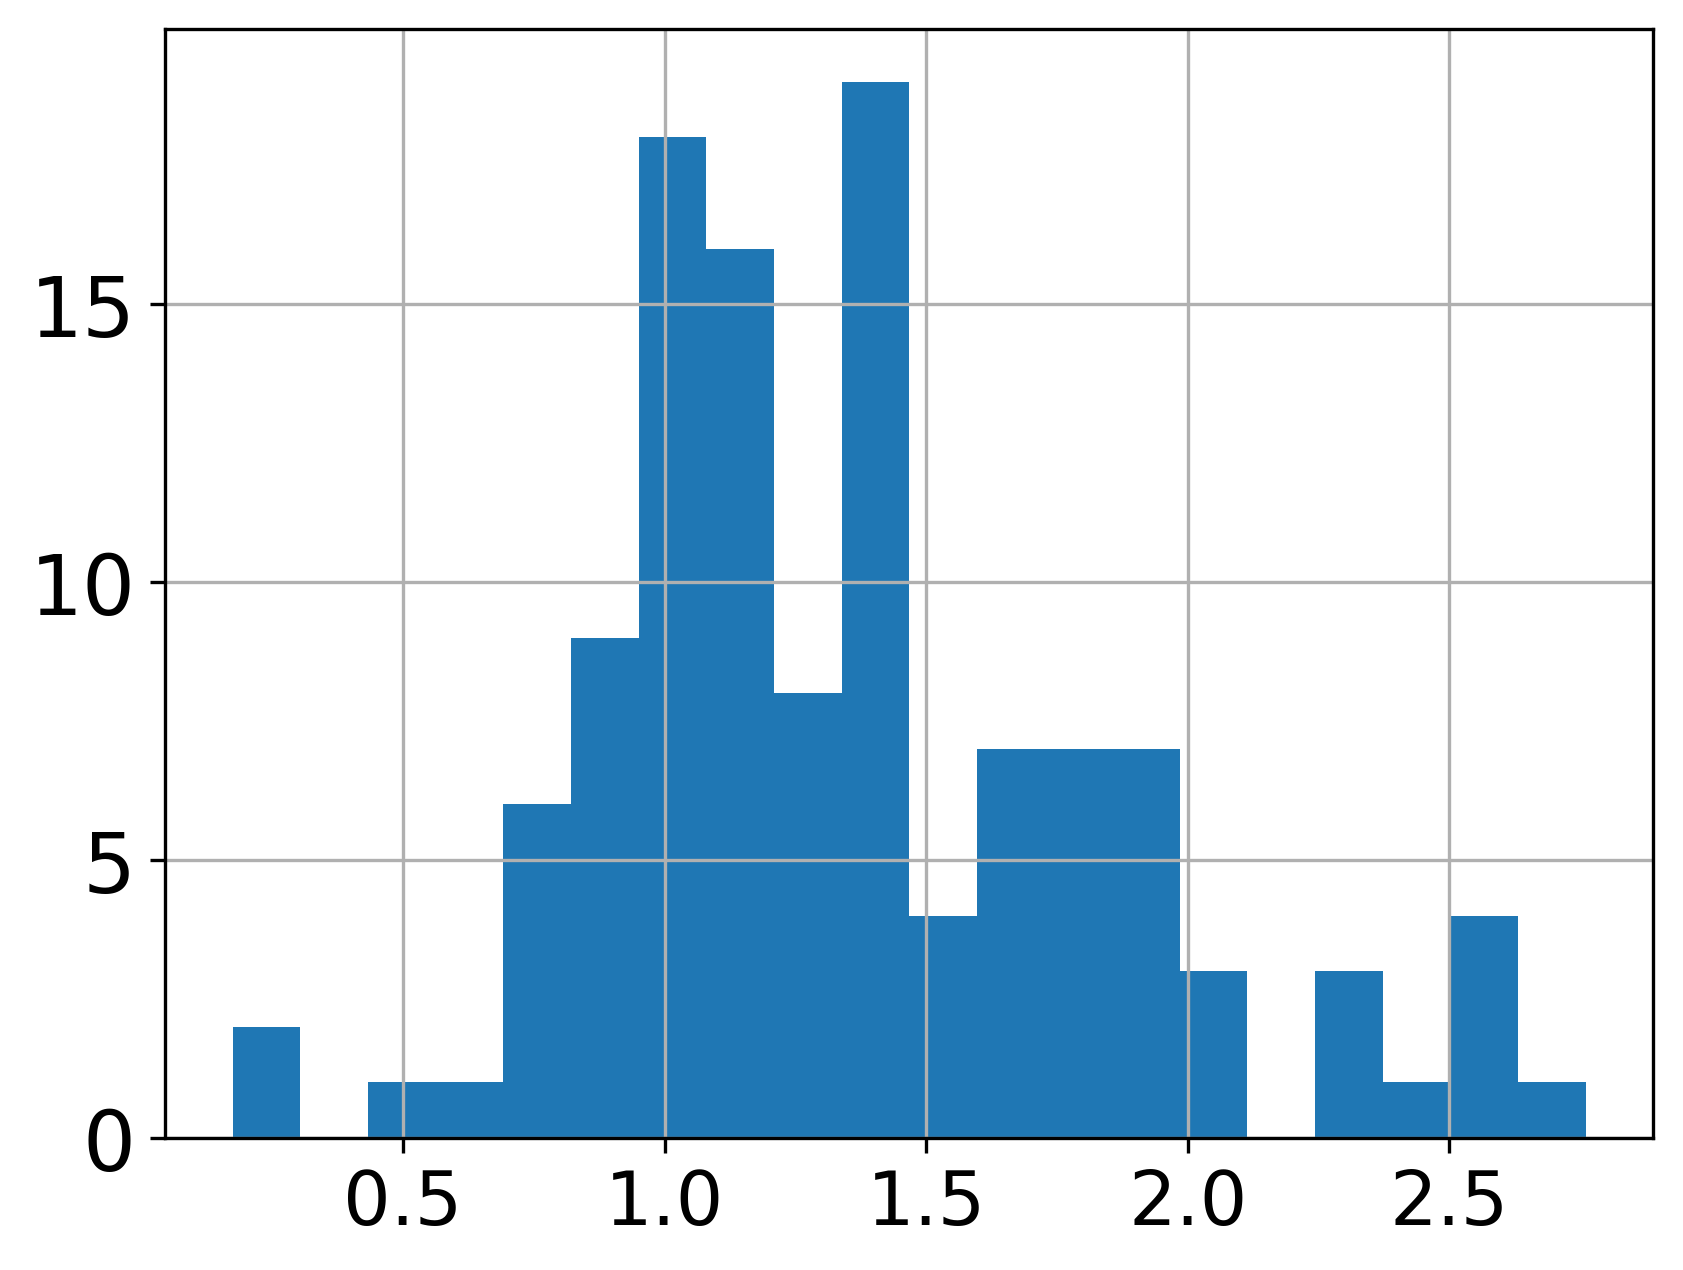

In [12]:
all_data['capacity_mean'].hist(bins=20)

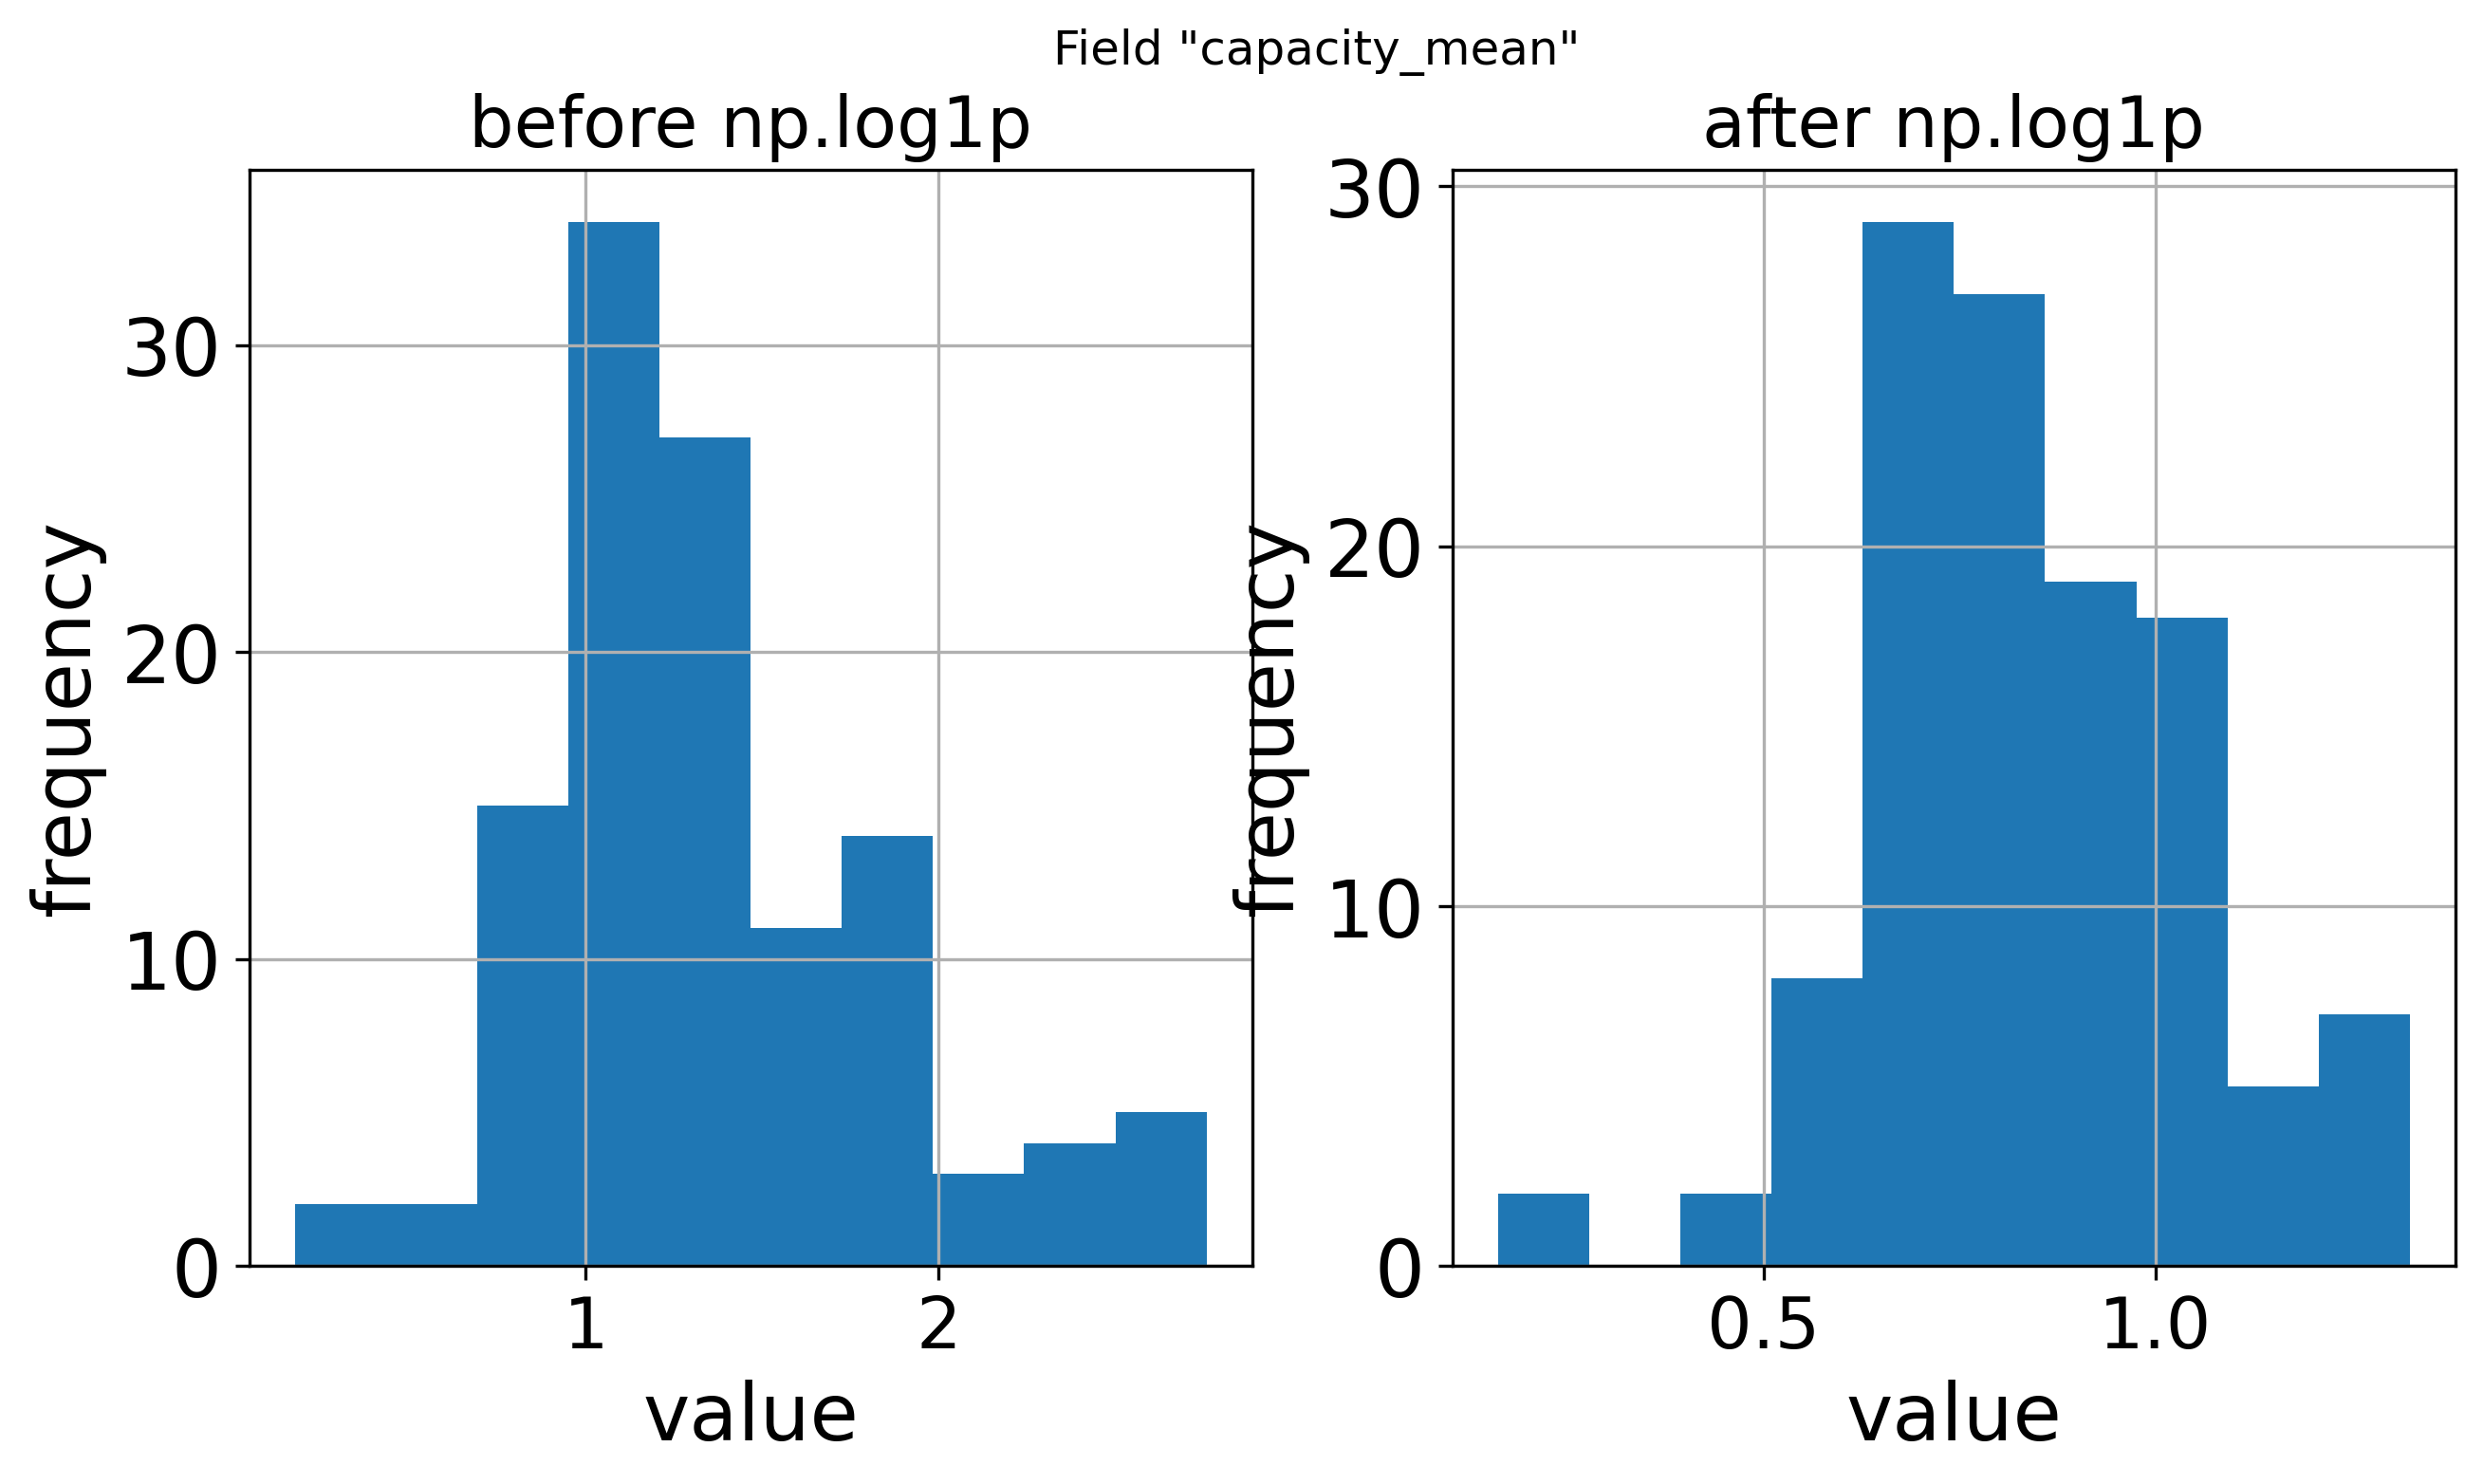

In [13]:
# Let's look at what happens to one of these features, when we apply np.log visually.

# Choose a field
field = "capacity_mean"
# Create two "subplots" and a "figure" using matplotlib
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))

# Create a histogram on the "ax_before" subplot
all_data[field].hist(ax=ax_before)

# Apply a log transformation (numpy syntax) to this column
all_data[field].apply(np.log1p).hist(ax=ax_after)

# Formatting of titles etc. for each subplot
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));


In [14]:
skew_vals=np.log1p(all_data['capacity_mean']).skew()
skew_vals

-0.12851866784147378

In [15]:
max_y=np.max(all_data.iloc[:,-1],axis=0)
min_y=np.min(all_data.iloc[:,-1],axis=0)
lims = [min_y, max_y]

In [16]:
num_overexpress=25
num_knockout=6
gene_num=num_overexpress+num_knockout
X, Y = all_data.iloc[:, 0:gene_num], np.log1p(all_data.iloc[:, -1])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [17]:
test_results = {}

In [19]:
X_train.shape

(105, 31)

## Linear Regression

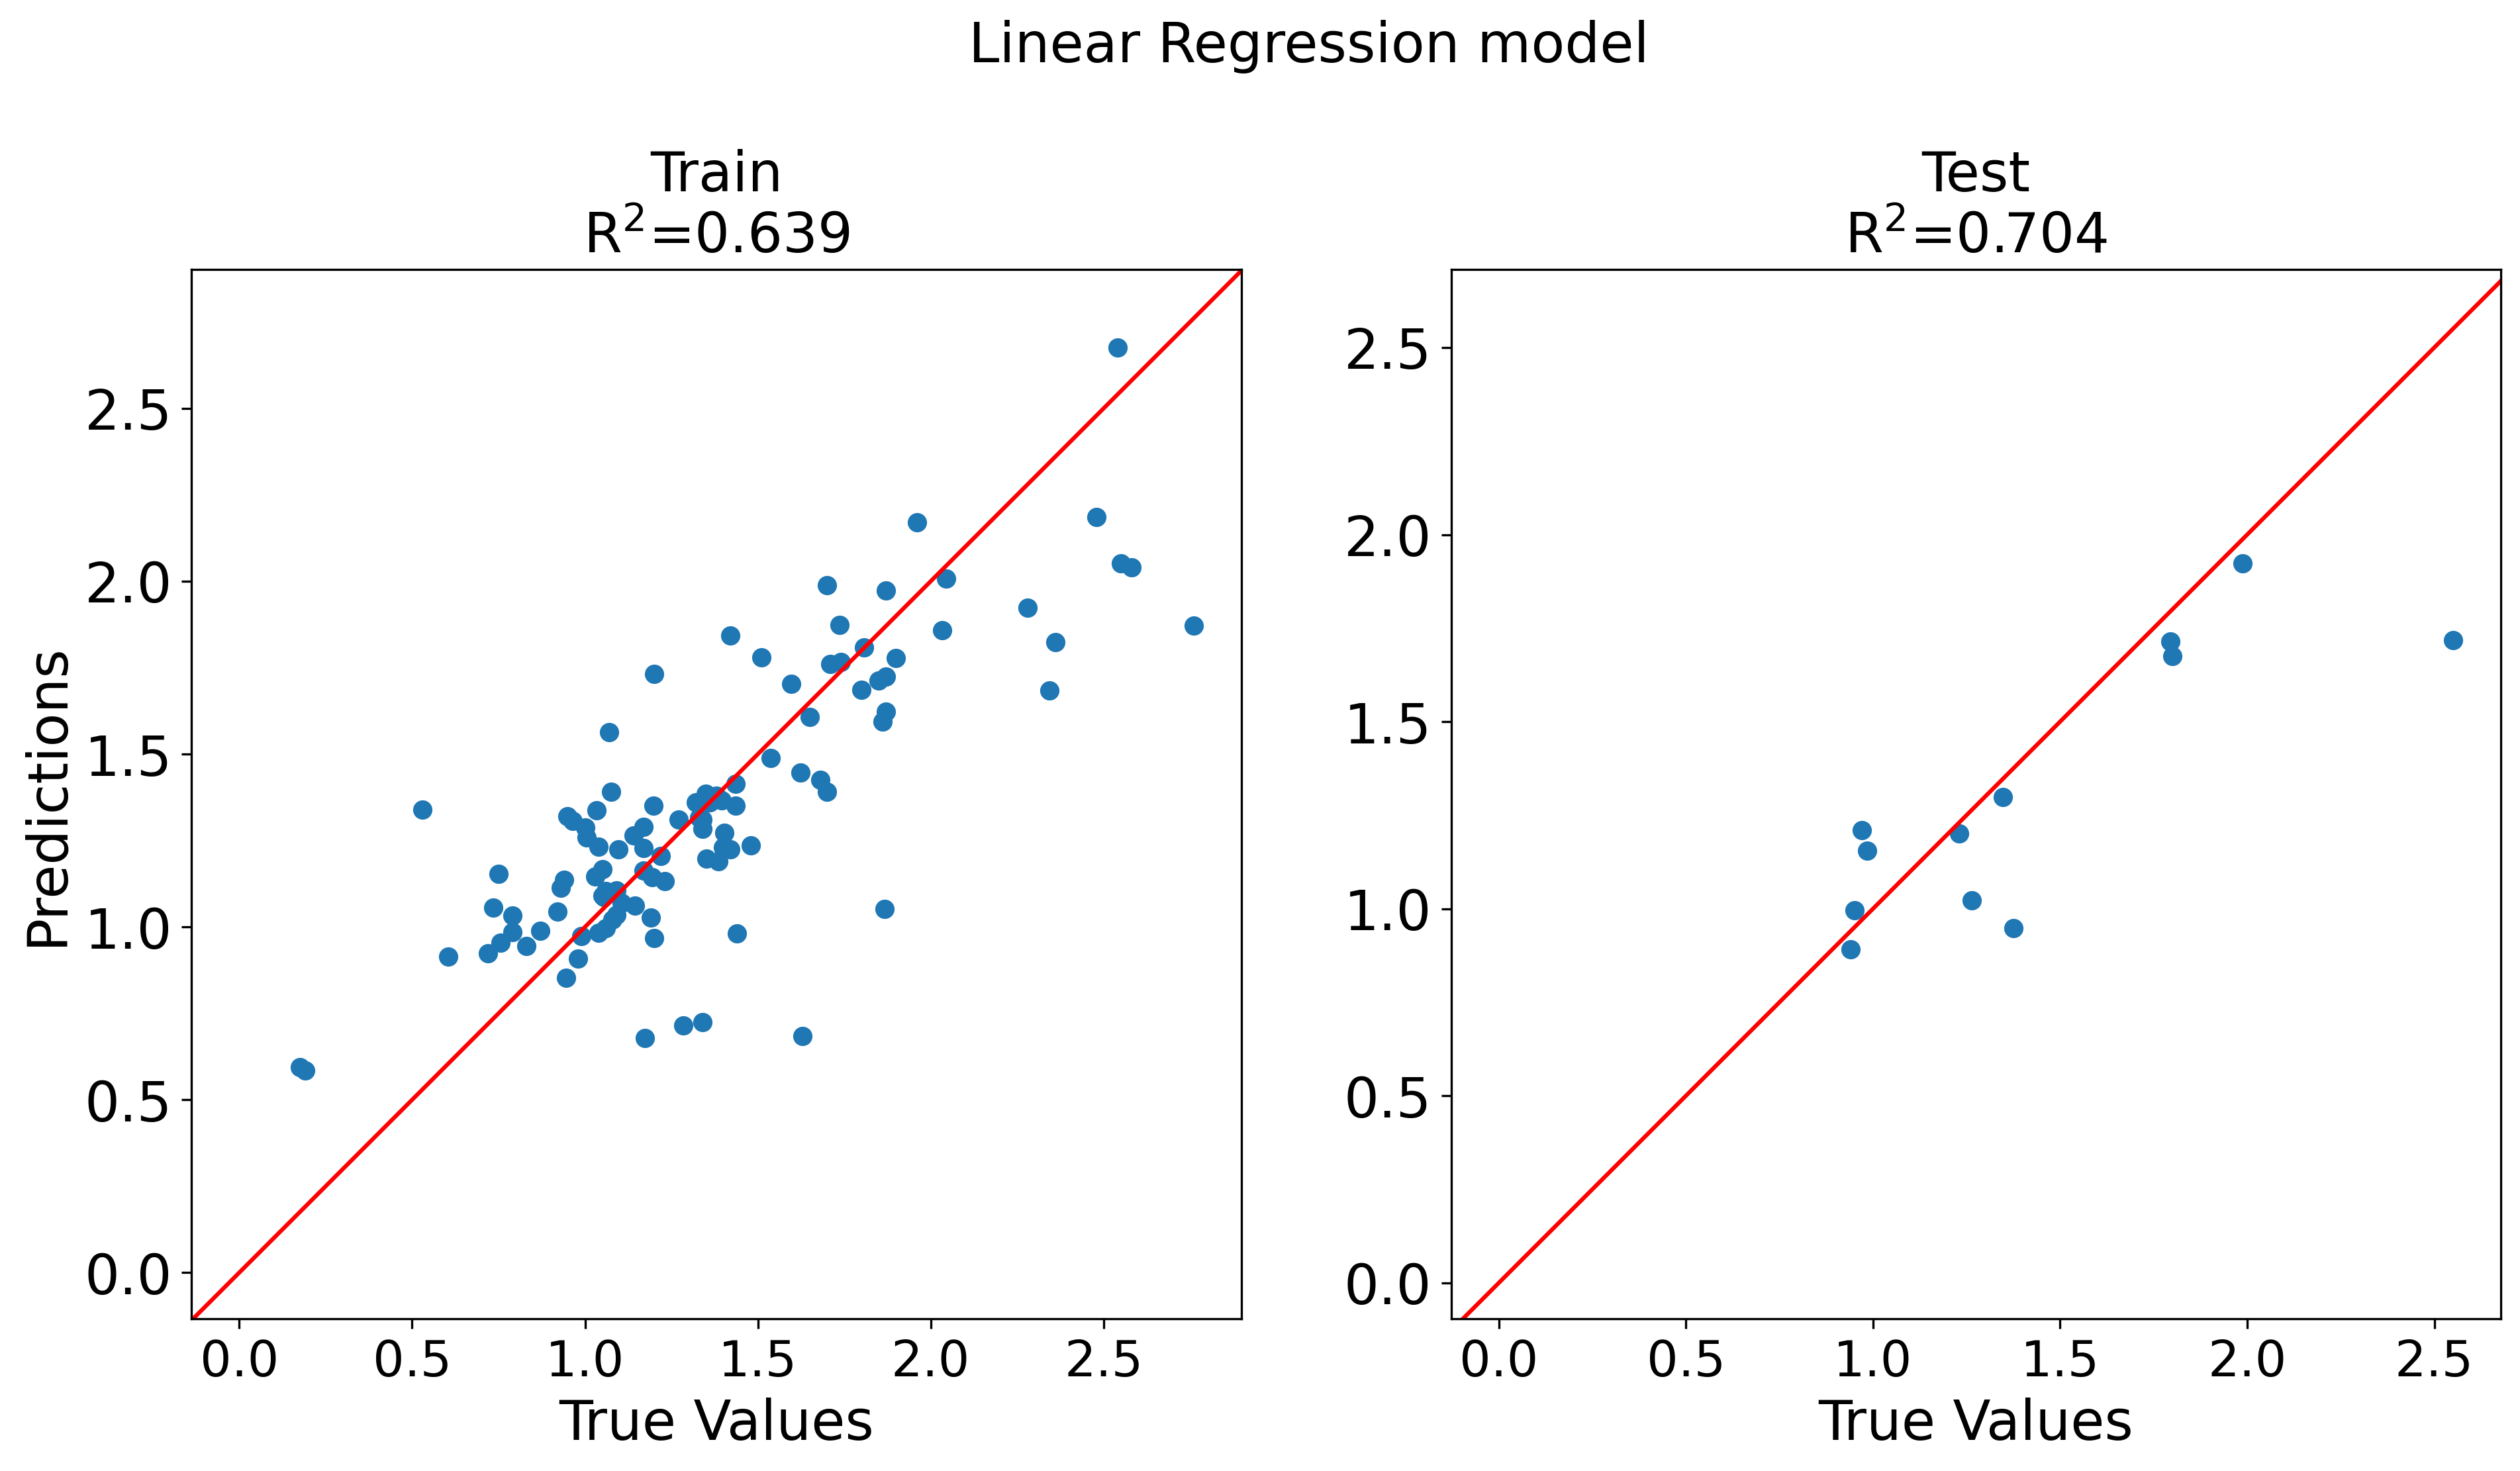

In [20]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
y_pred_train = linear_model.predict(X_train).squeeze()
y_pred_test = linear_model.predict(X_test).squeeze()
model_name = "Linear Regression model"
plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

## SVM Regression

In [21]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(X_train, Y_train)

SVR()

In [22]:
y_pred_train = svm_reg.predict(X_train)
y_pred_test = svm_reg.predict(X_test)
test_results['SVR'] = metrics.mean_squared_error(Y_test, y_pred_test)

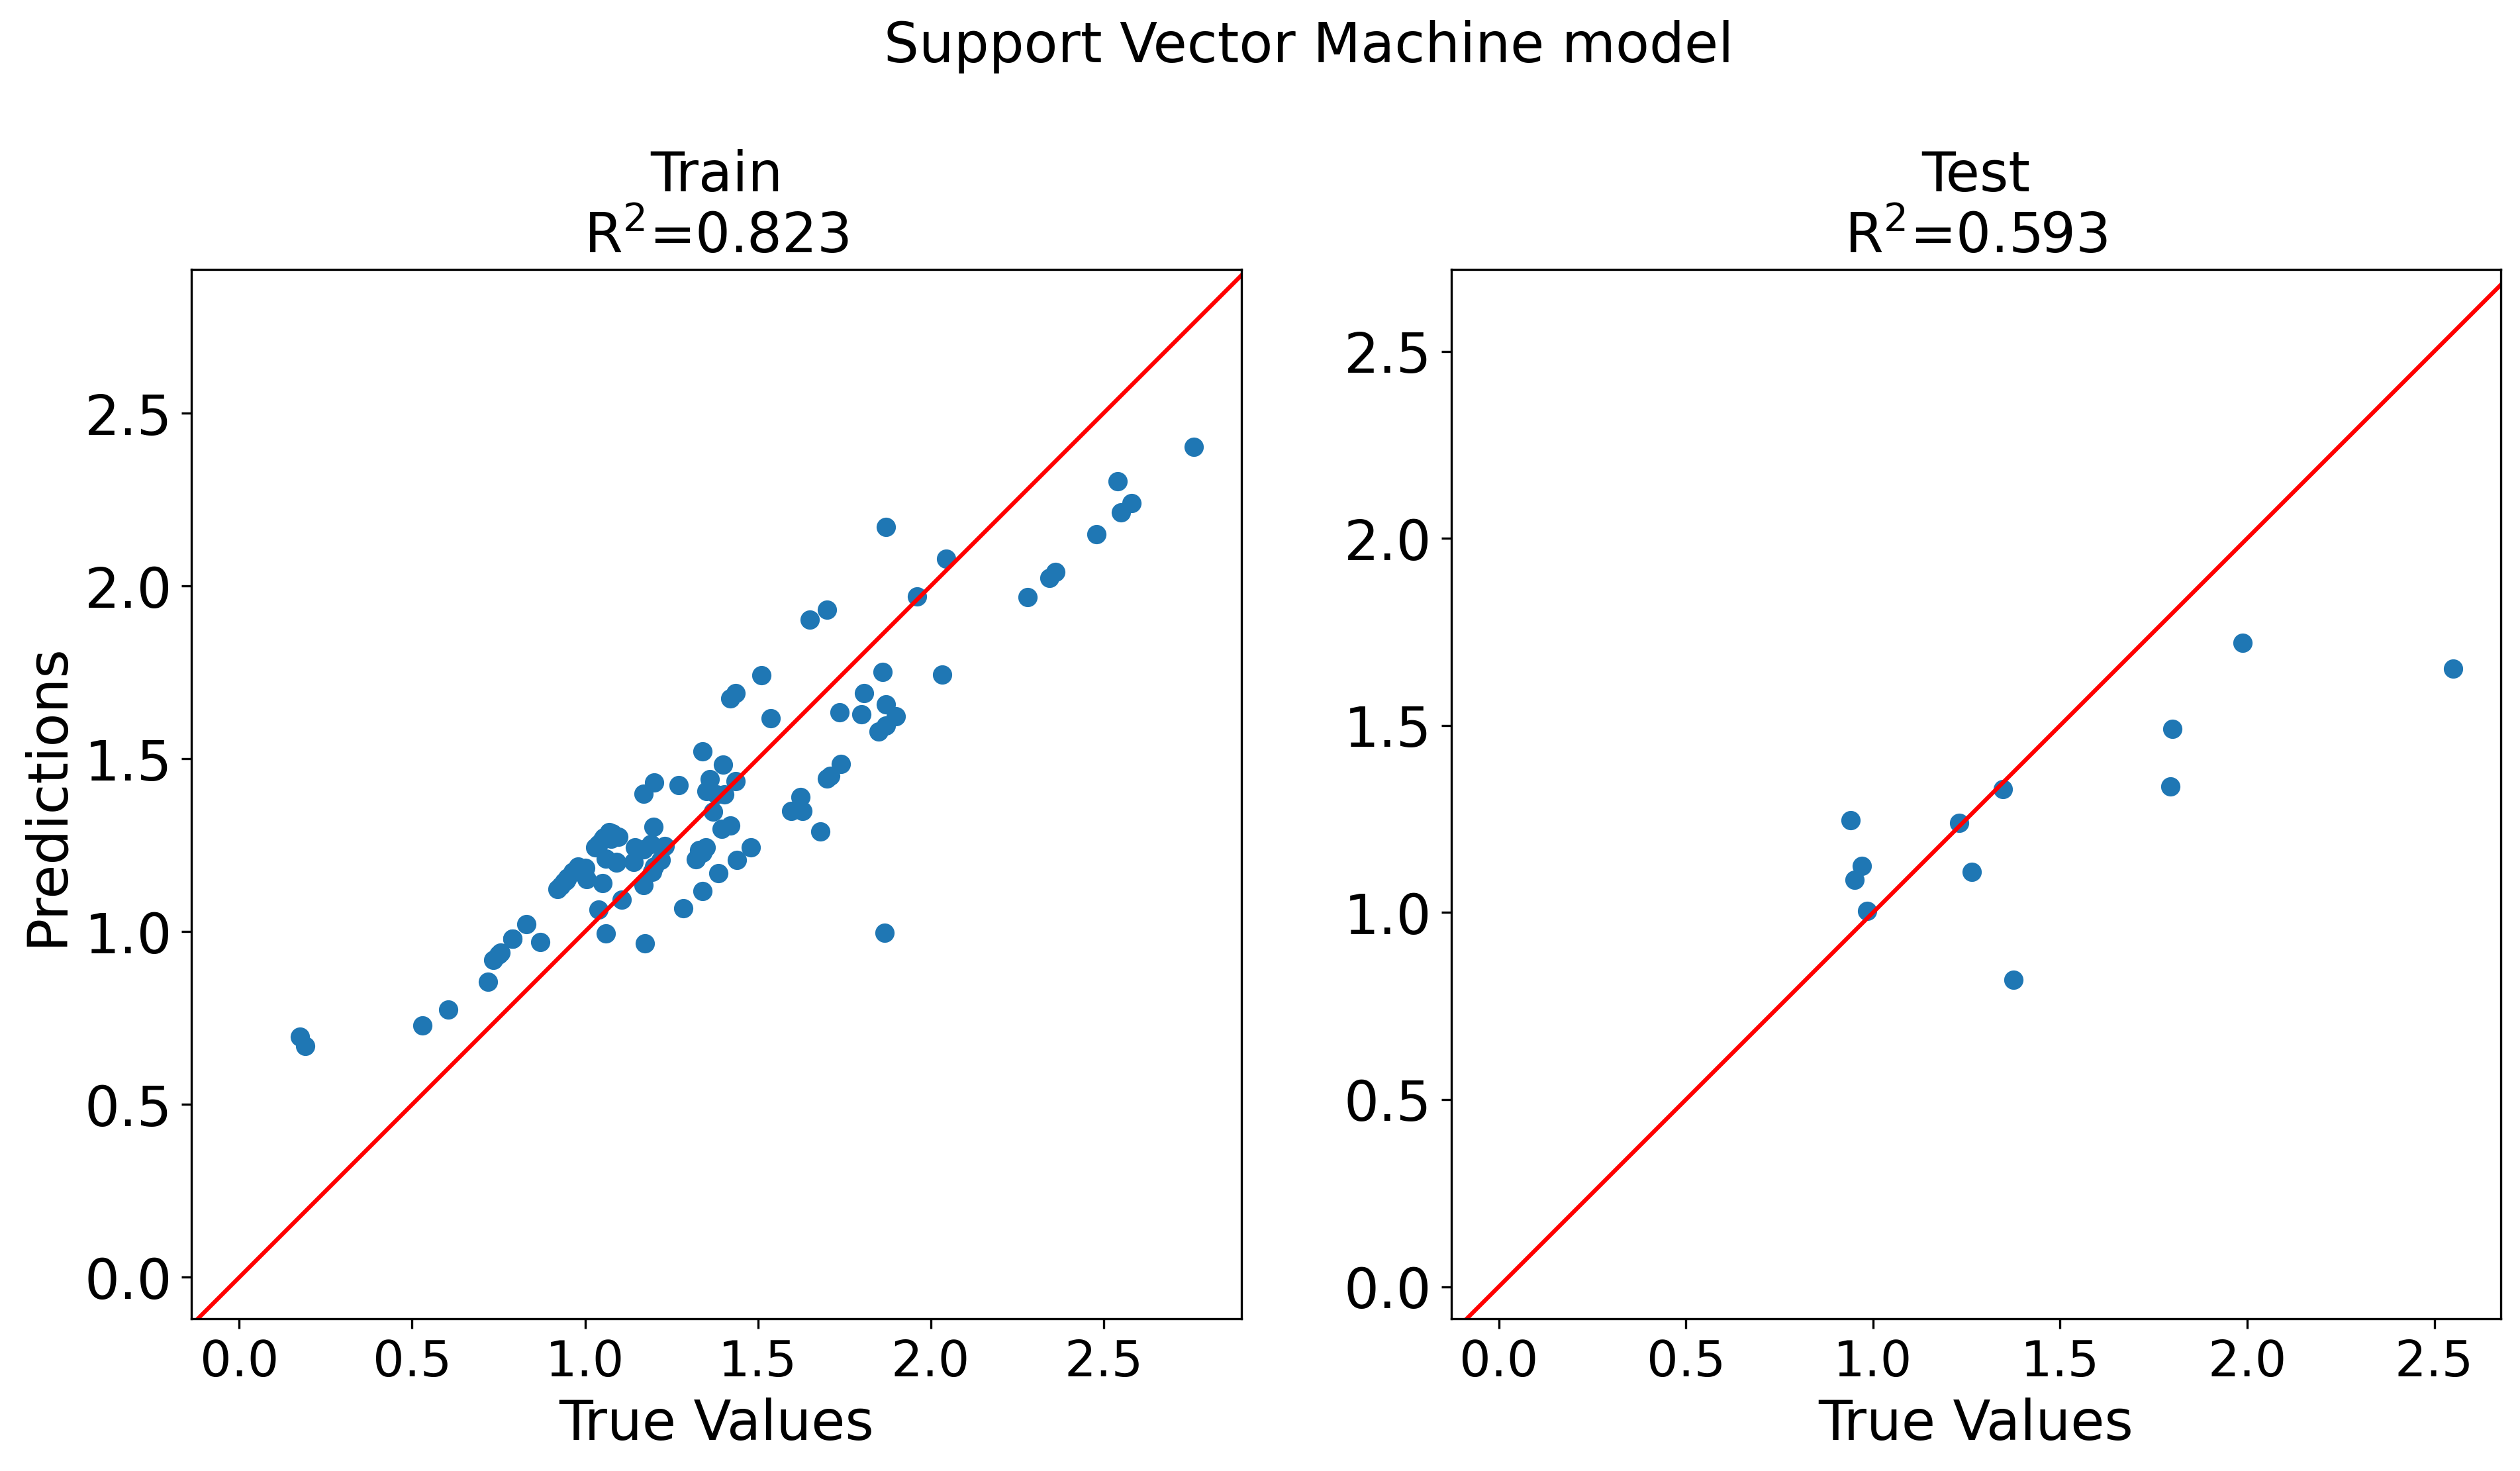

In [23]:
model_name = "Support Vector Machine model"
plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

In [24]:
svm_reg.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Grid searching

In [25]:
param_grid = [
{ 'C' : [0.5, 1.0, 1.5, 2.0, 2.5],  'epsilon': [0.1, 0.15, 0.2]}]
svr = SVR()
svr_grid = GridSearchCV(svr, param_grid, cv=3, verbose=1)
svr_hist = svr_grid.fit(X_train, Y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [26]:
svr_hist.best_params_

{'C': 0.5, 'epsilon': 0.1}

In [27]:
svm_best = SVR(**svr_hist.best_params_)
svm_best.fit(X_train, Y_train)

SVR(C=0.5)

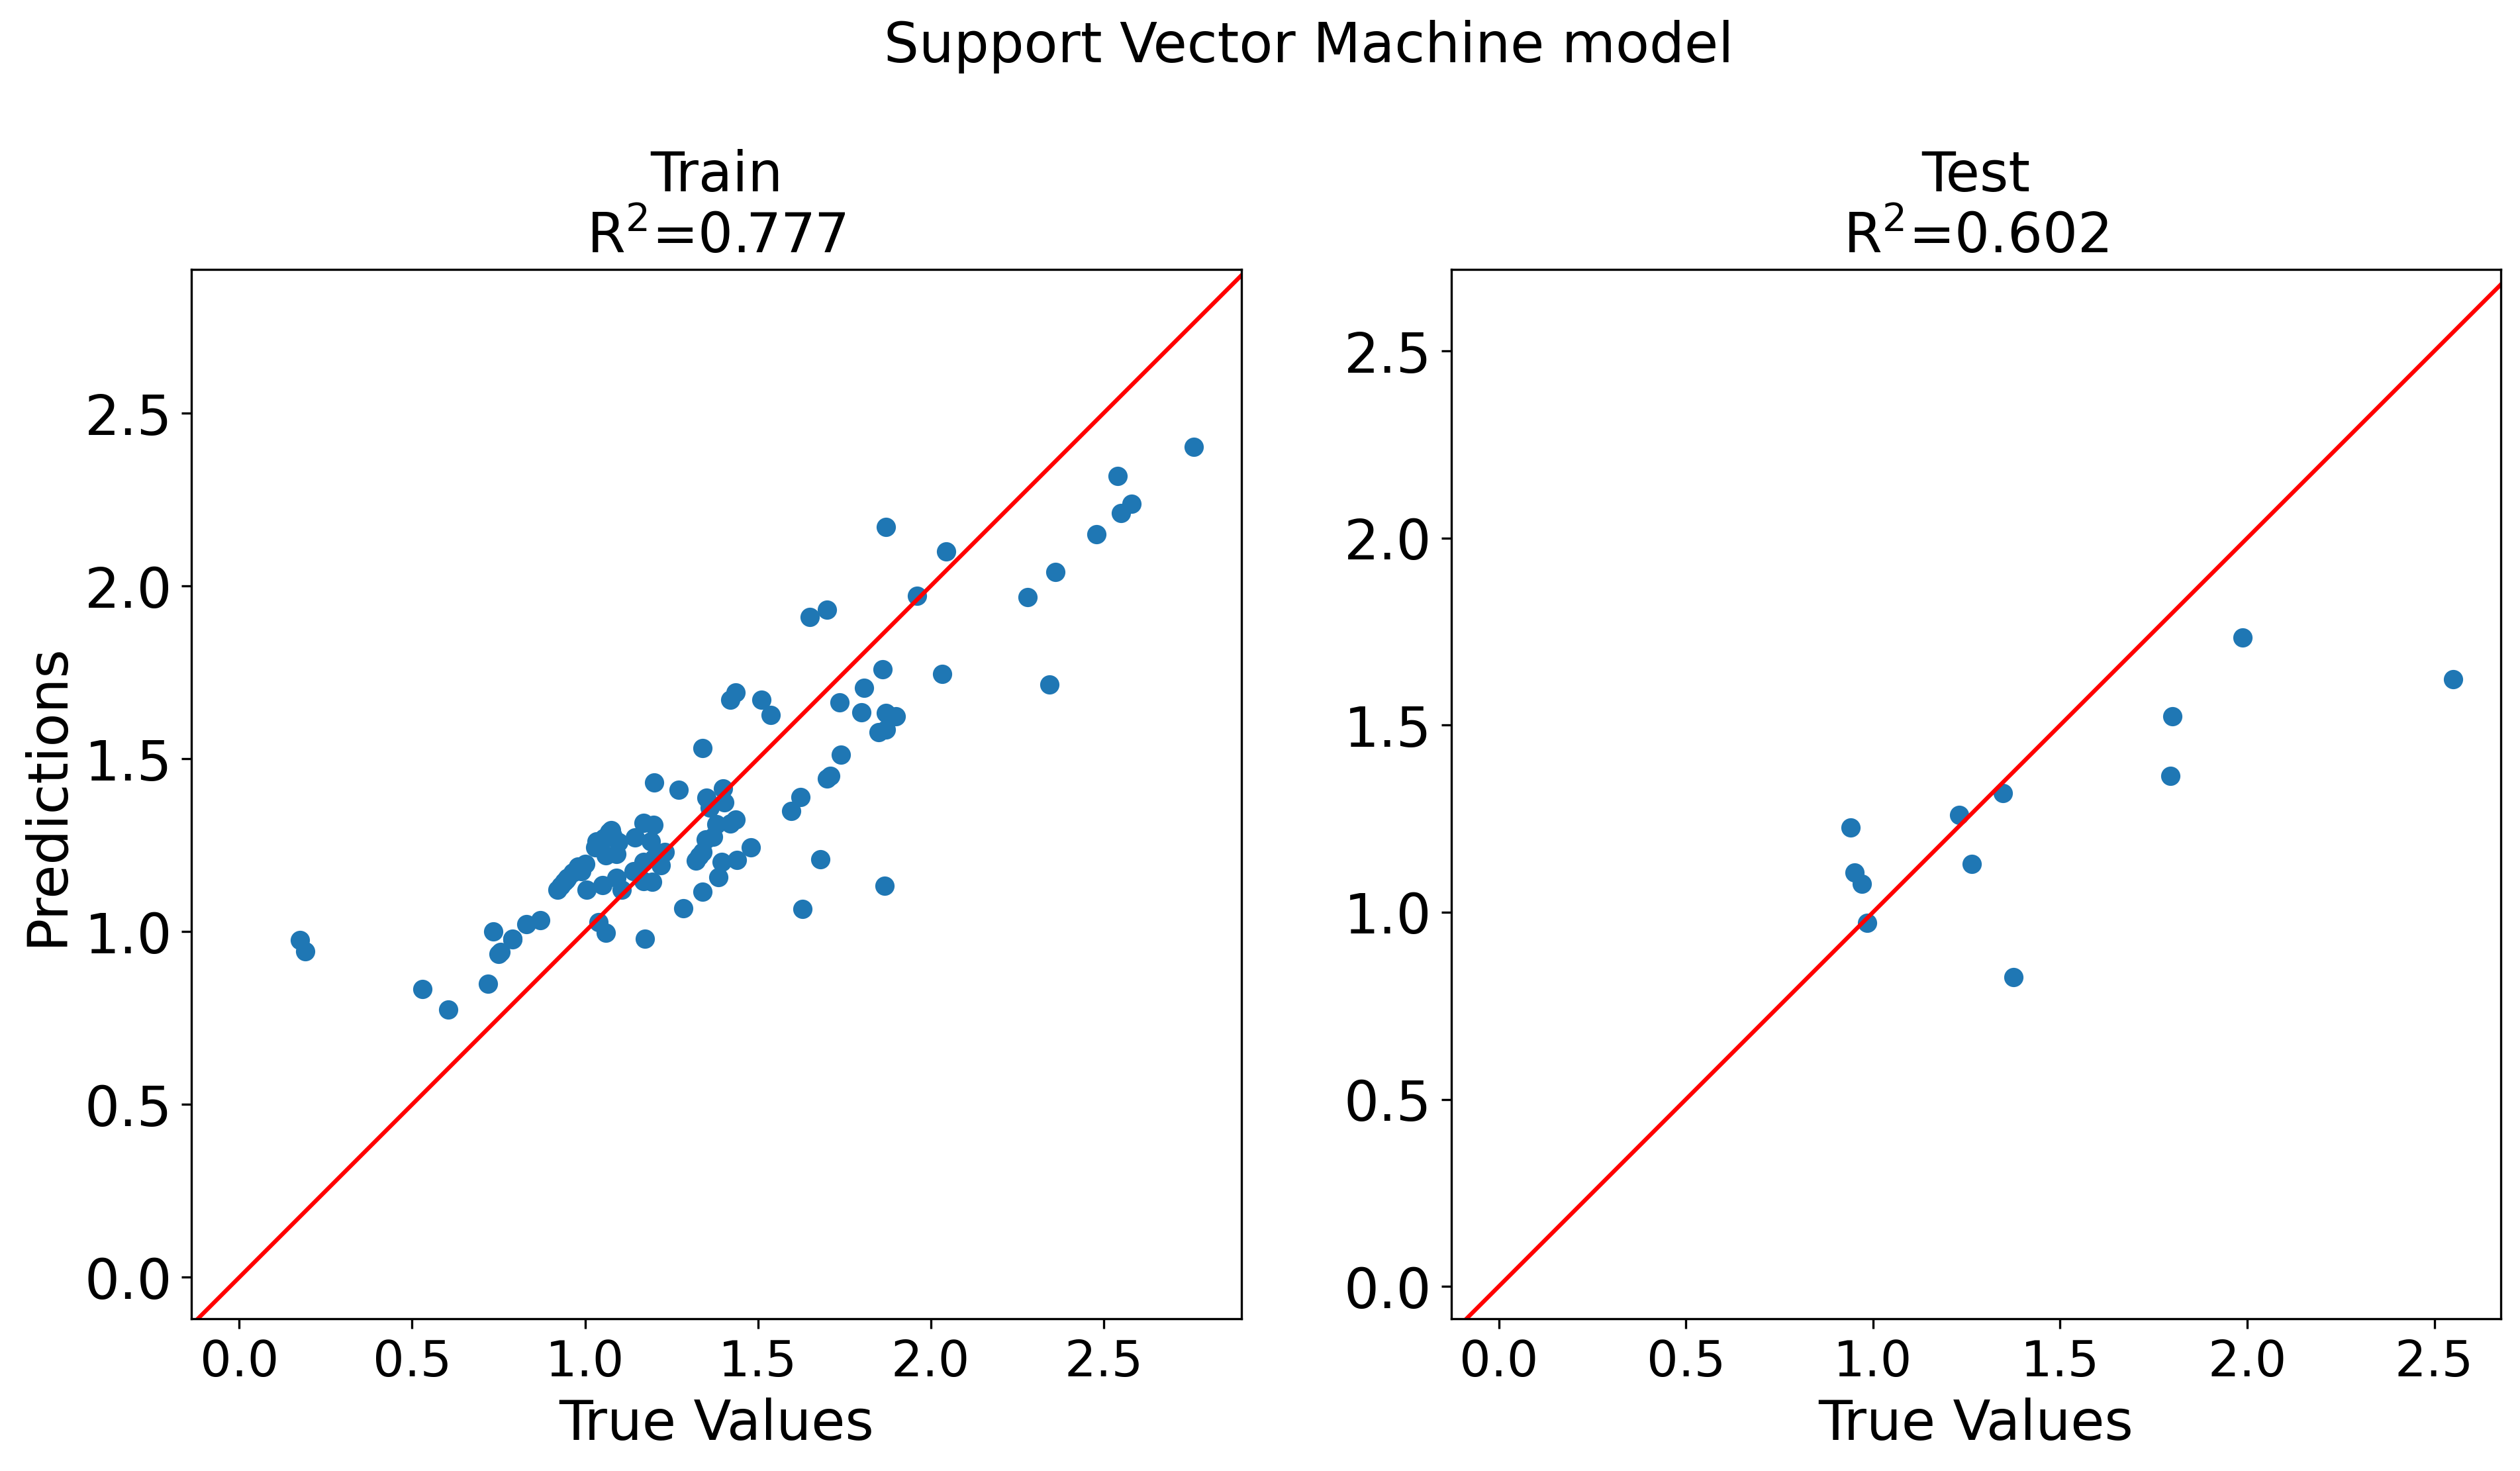

In [28]:
y_pred_train = svm_best.predict(X_train)
y_pred_test = svm_best.predict(X_test)
test_results['SVR'] = metrics.mean_squared_error(Y_test, y_pred_test)
model_name = "Support Vector Machine model"
plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)


Decision Forests (DF) are a large family of Machine Learning algorithms for supervised classification, regression and ranking. As the name suggests, DFs use decision trees as a building block. The two most popular DF training algorithms are Random Forests and Gradient Boosted Decision Trees. Both algorithms are ensemble techniques that use multiple decision trees, but differ on how they do it.

## Random Forest Regression

In [29]:
# Random forest regressor
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(random_state=42)
## fit the regressor with x and y data
RF_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [30]:
y_pred_train = RF_model.predict(X_train)
y_pred_test = RF_model.predict(X_test)
test_results['RF_model'] = metrics.mean_squared_error(Y_test, y_pred_test)

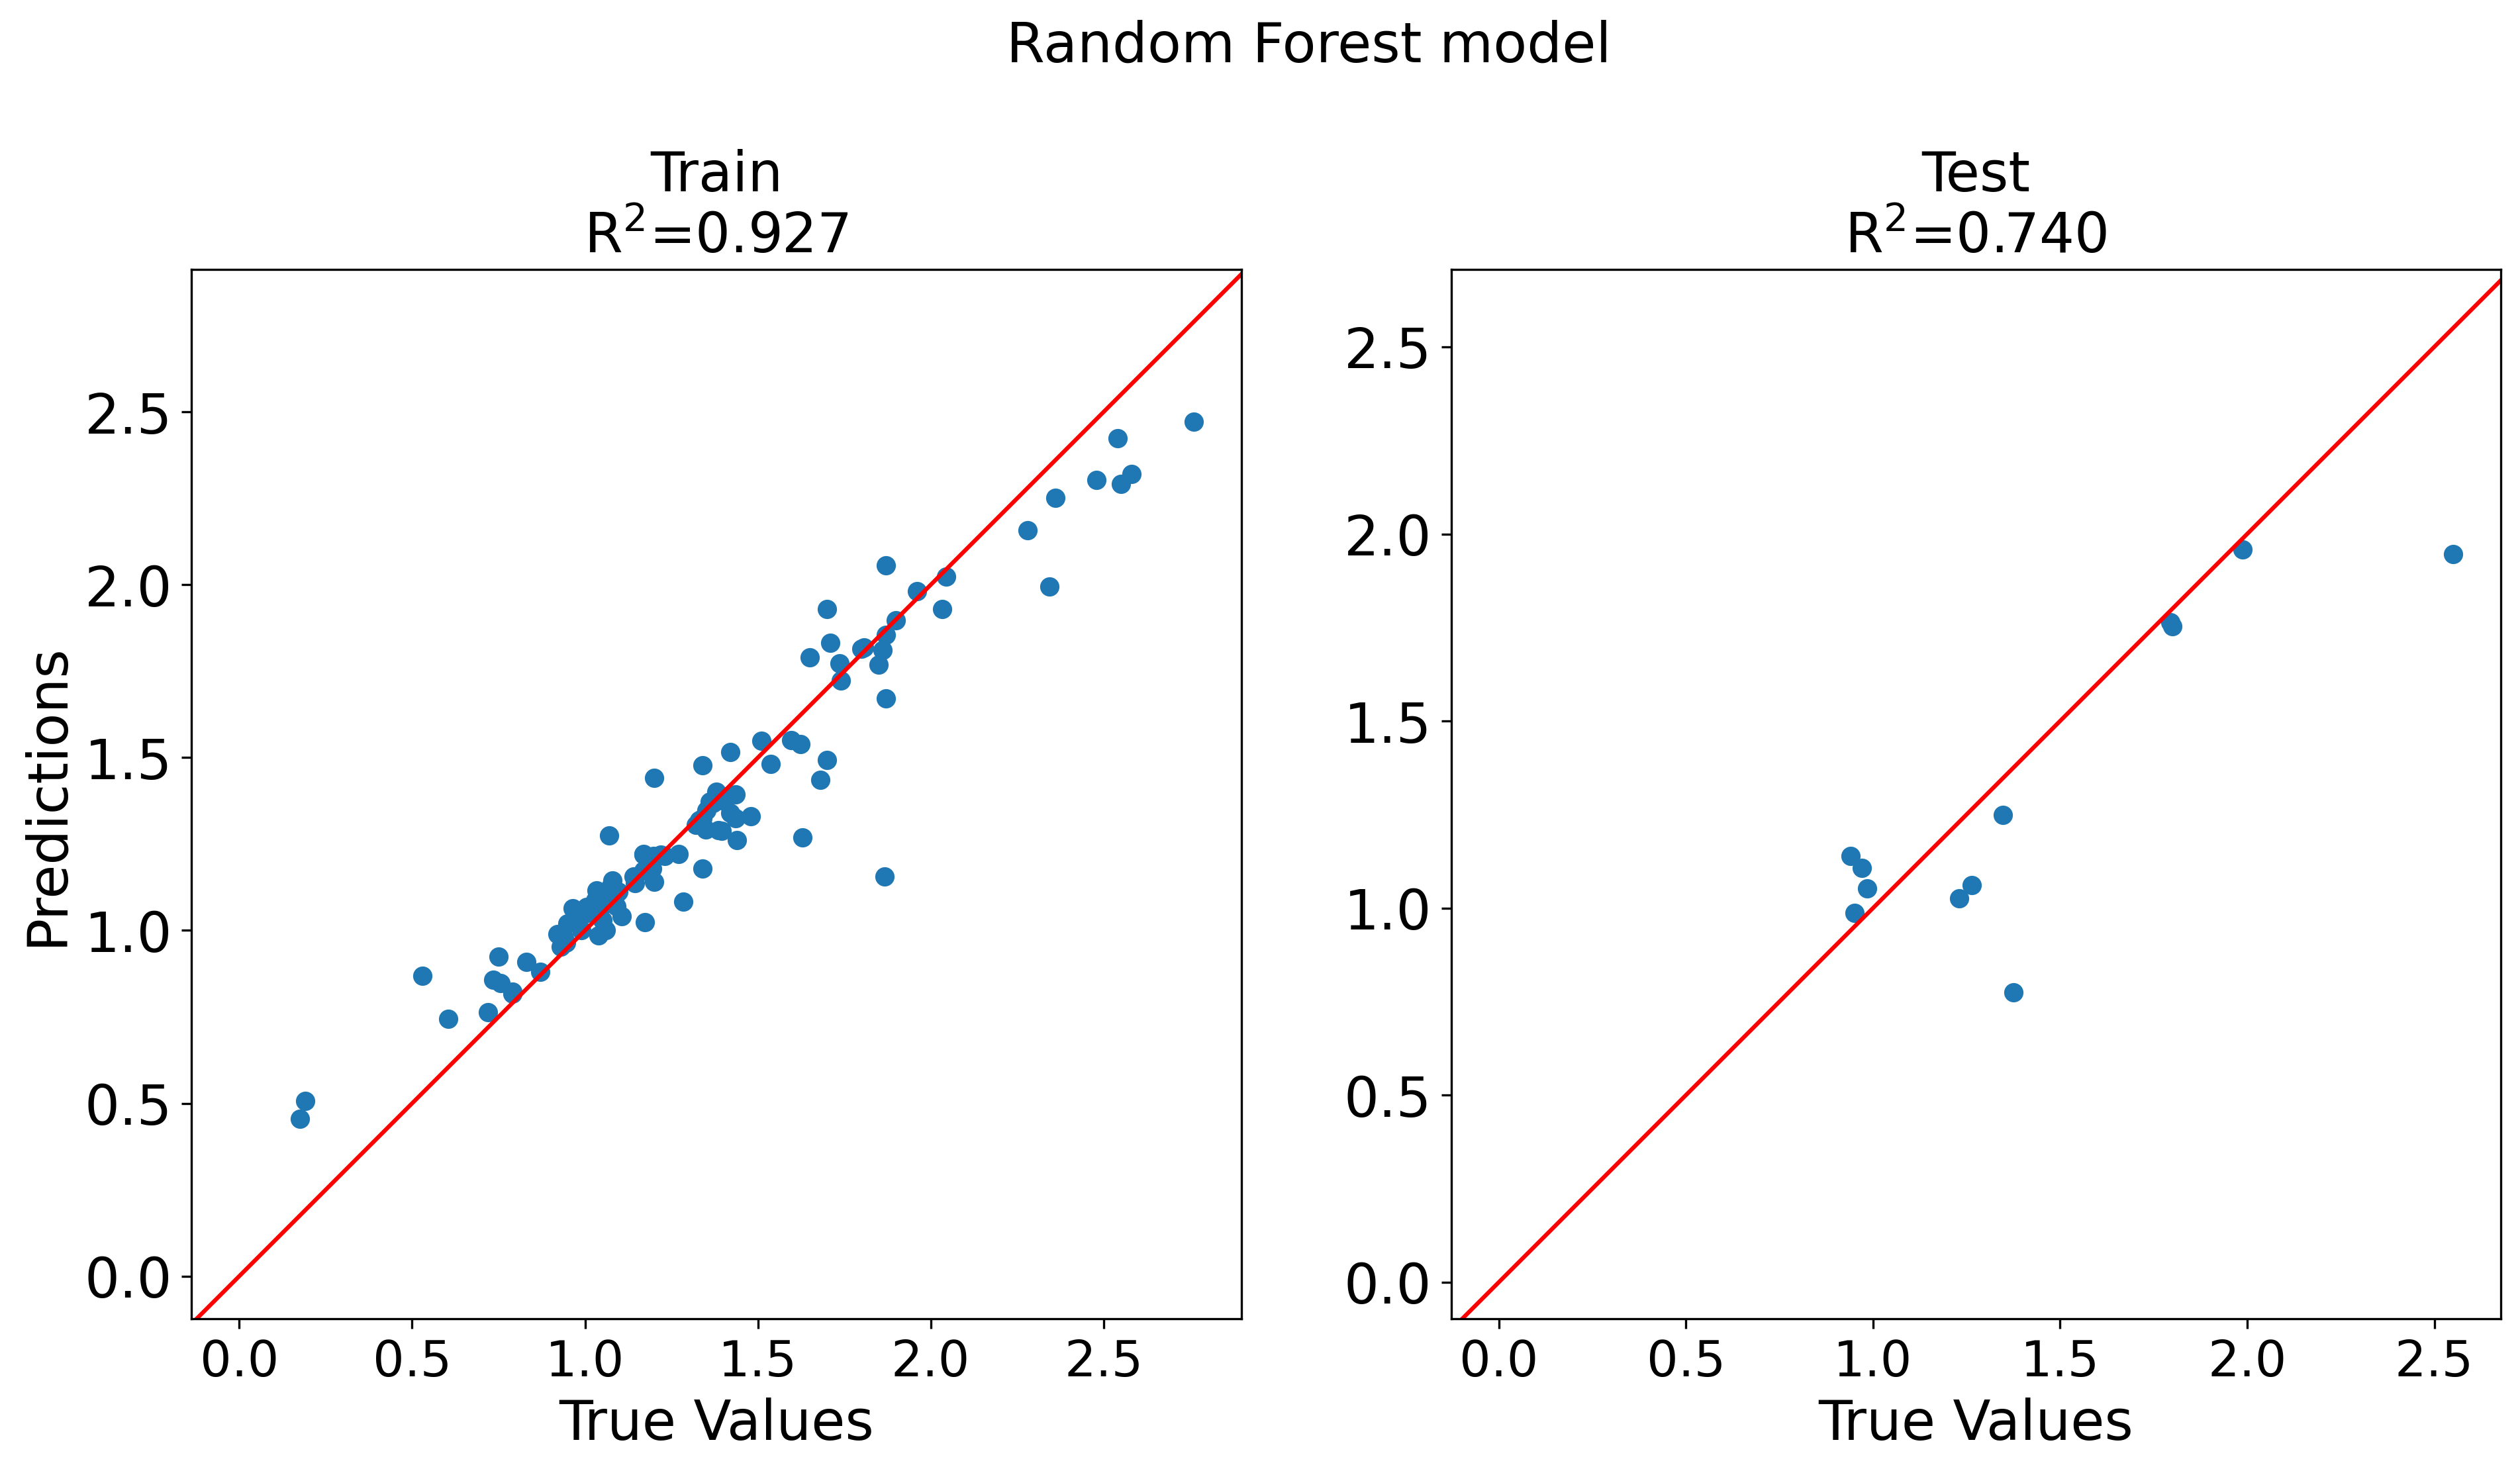

In [31]:
model_name = "Random Forest model"
plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

In [35]:
RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Grid searching

In [32]:
param_grid = [{'max_depth': [2, 3, 4, None], 'n_estimators': [100, 150, 200] }]
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, param_grid, cv=3, verbose=0)
rf_hist = rf_grid.fit(X_train, Y_train)

In [33]:
rf_hist.best_params_

{'max_depth': None, 'n_estimators': 150}

In [34]:
RF_best = RandomForestRegressor(**rf_hist.best_params_, random_state=42)
RF_best.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

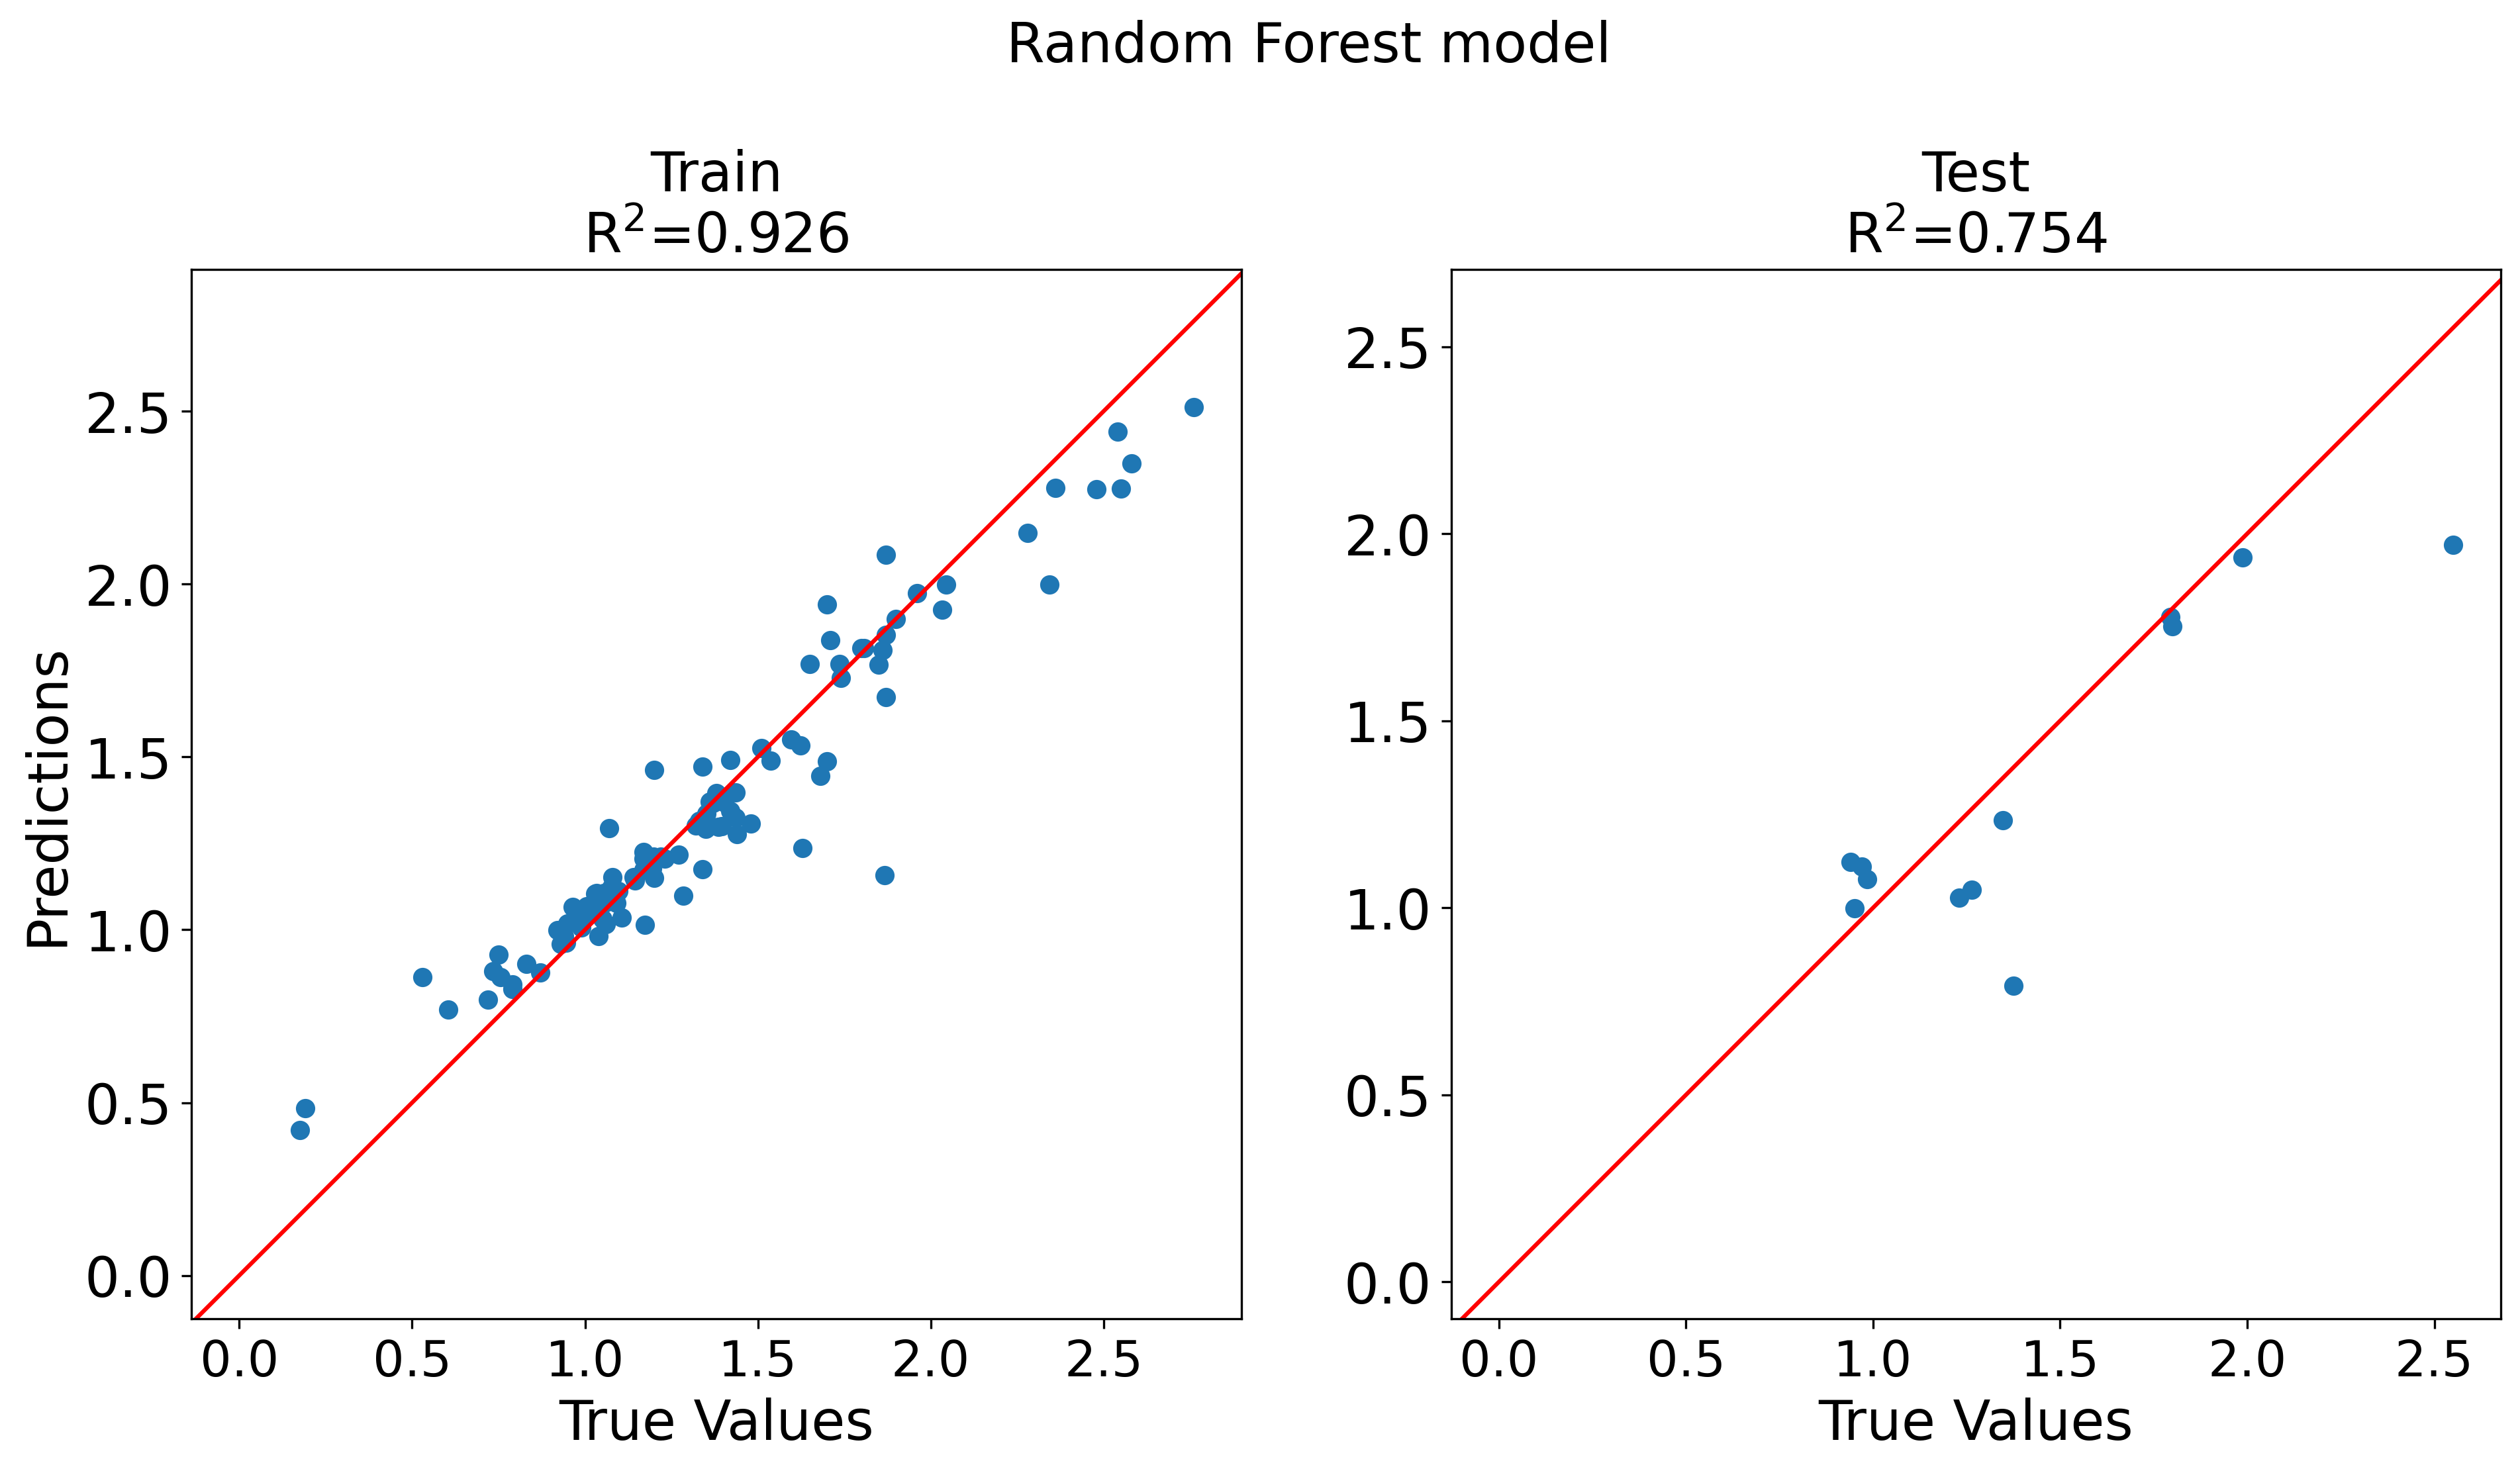

In [35]:
y_pred_train = RF_best.predict(X_train)
y_pred_test = RF_best.predict(X_test)
test_results['RF_model'] = metrics.mean_squared_error(Y_test, y_pred_test)

model_name = "Random Forest model"
plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)


## Gradient Boosting Regression

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt_model=GradientBoostingRegressor(random_state=42)
gbrt_model.fit(X_train, Y_train)

GradientBoostingRegressor(random_state=42)

In [37]:
y_pred_train = gbrt_model.predict(X_train)
y_pred_test = gbrt_model.predict(X_test)
test_results['GBRT'] = metrics.mean_squared_error(Y_test, y_pred_test)

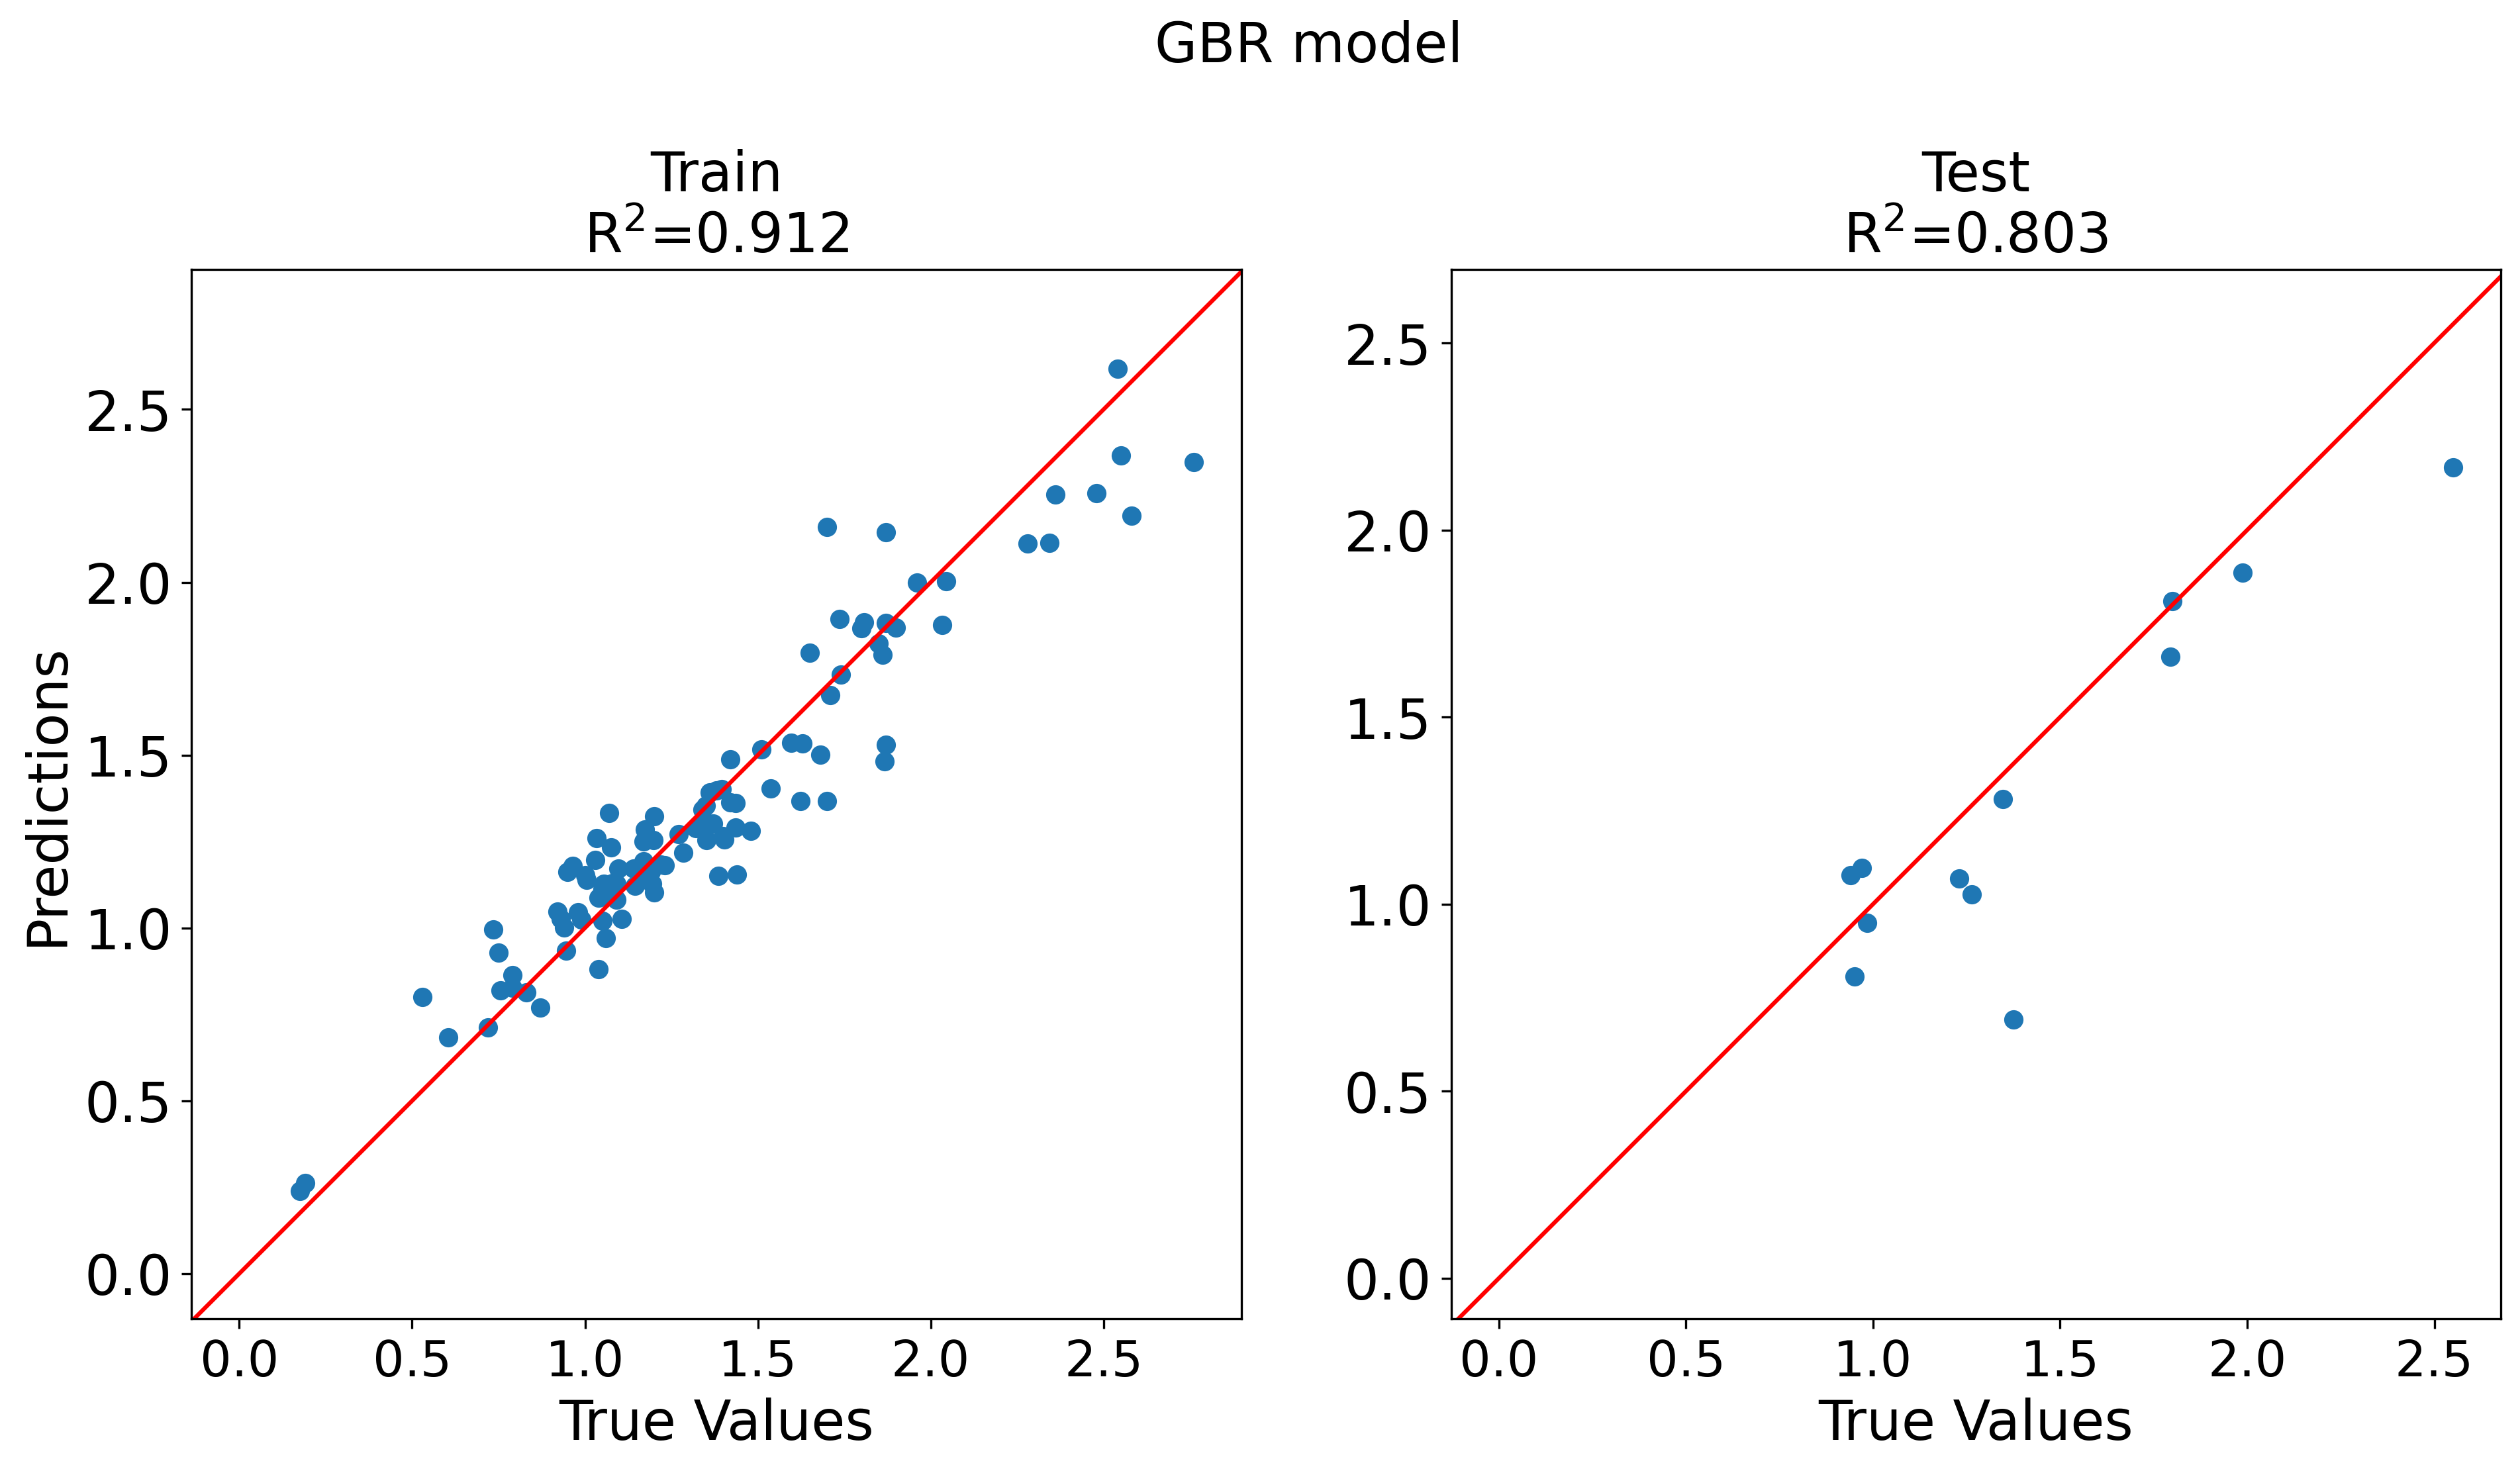

In [38]:
model_name = "GBR model"
plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

In [39]:
gbrt_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Grid searching

In [40]:
param_grid = [{'max_depth': [2, 3, 4],  'learning_rate':[0.1, 0.15, 0.2], 'n_estimators': [100, 150, 200] }]
gbrt = GradientBoostingRegressor(random_state=42)
gbrt_grid = GridSearchCV(gbrt, param_grid, cv=3, verbose=1)
gbrt_hist = gbrt_grid.fit(X_train, Y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [41]:
gbrt_hist.best_params_

{'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 100}

In [42]:
gbrt_best = GradientBoostingRegressor(**gbrt_hist.best_params_,random_state=42)
gbrt_best.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.15, max_depth=4, random_state=42)

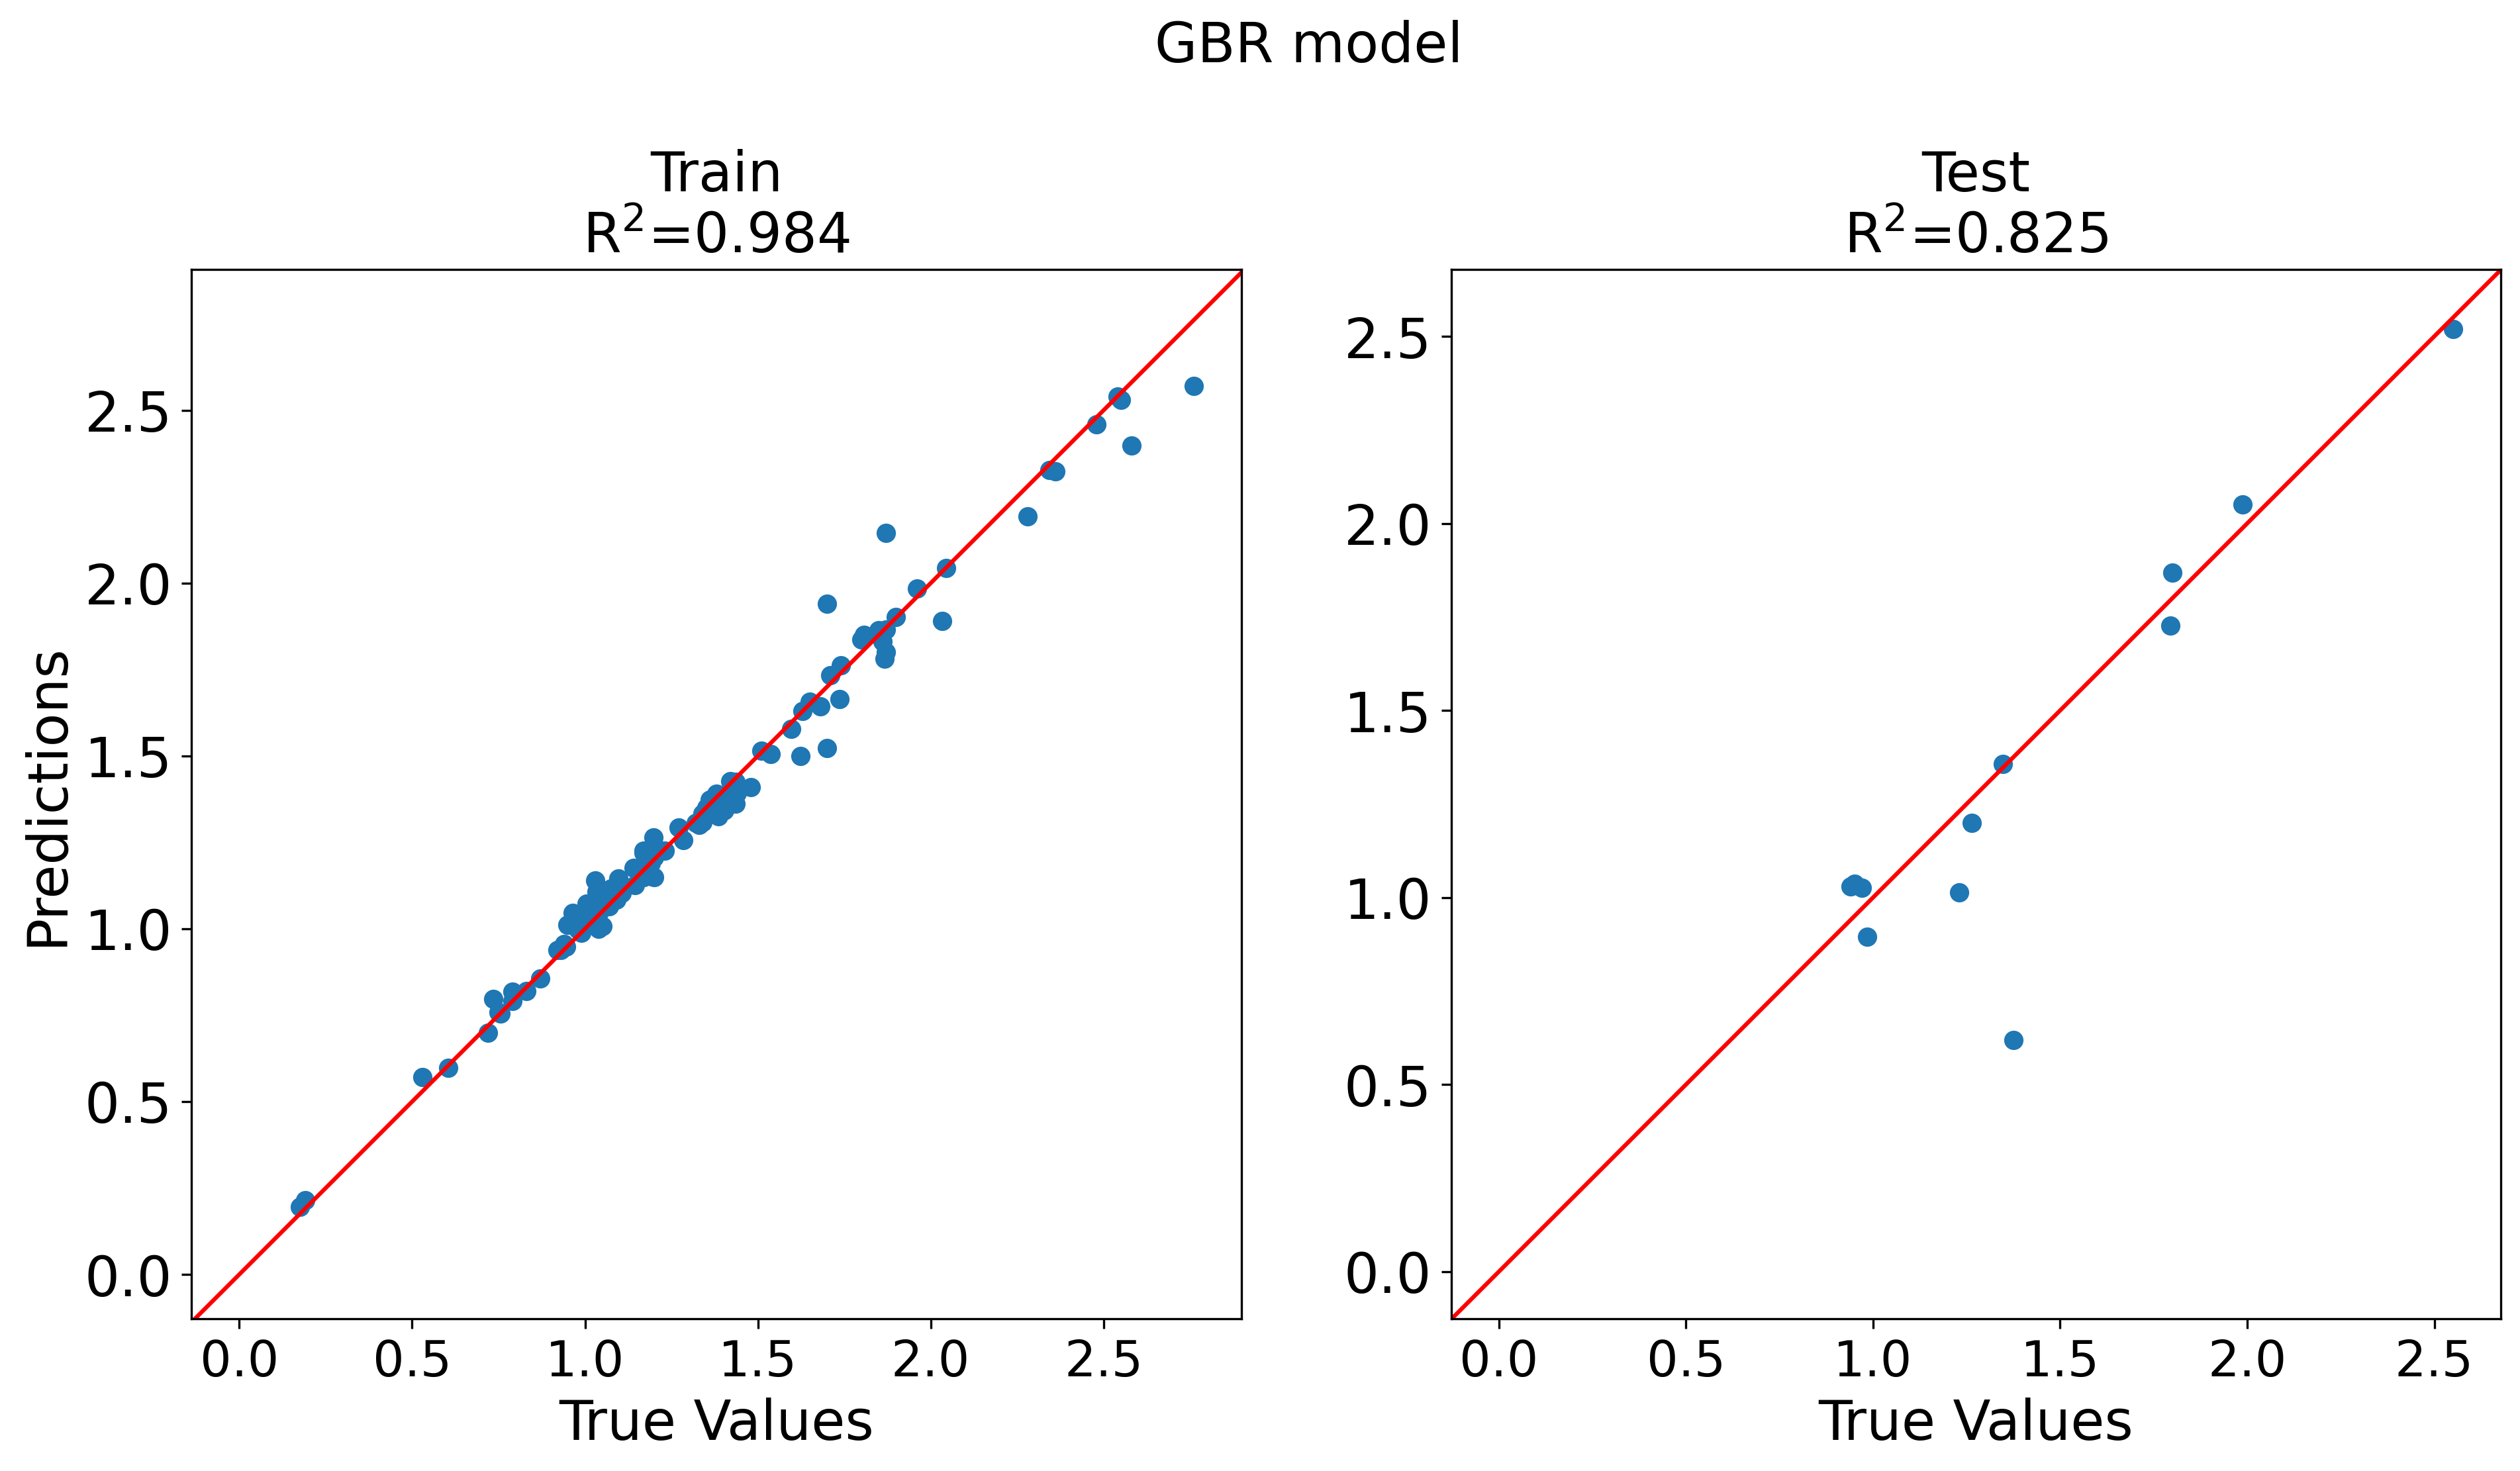

In [54]:
y_pred_train = gbrt_best.predict(X_train)
y_pred_test = gbrt_best.predict(X_test)
test_results['GBRT'] = metrics.mean_squared_error(Y_test, y_pred_test)

model_name = "GBR model"
plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)


## k-Nearest Neighbor Model

In [45]:
from sklearn.neighbors import KNeighborsRegressor

In [46]:
knn_model=KNeighborsRegressor()
knn_model.fit(X_train, Y_train)

KNeighborsRegressor()

In [47]:
y_pred_train = knn_model.predict(X_train)
y_pred_test = knn_model.predict(X_test)
test_results['KNN'] = metrics.mean_squared_error(Y_test, y_pred_test)

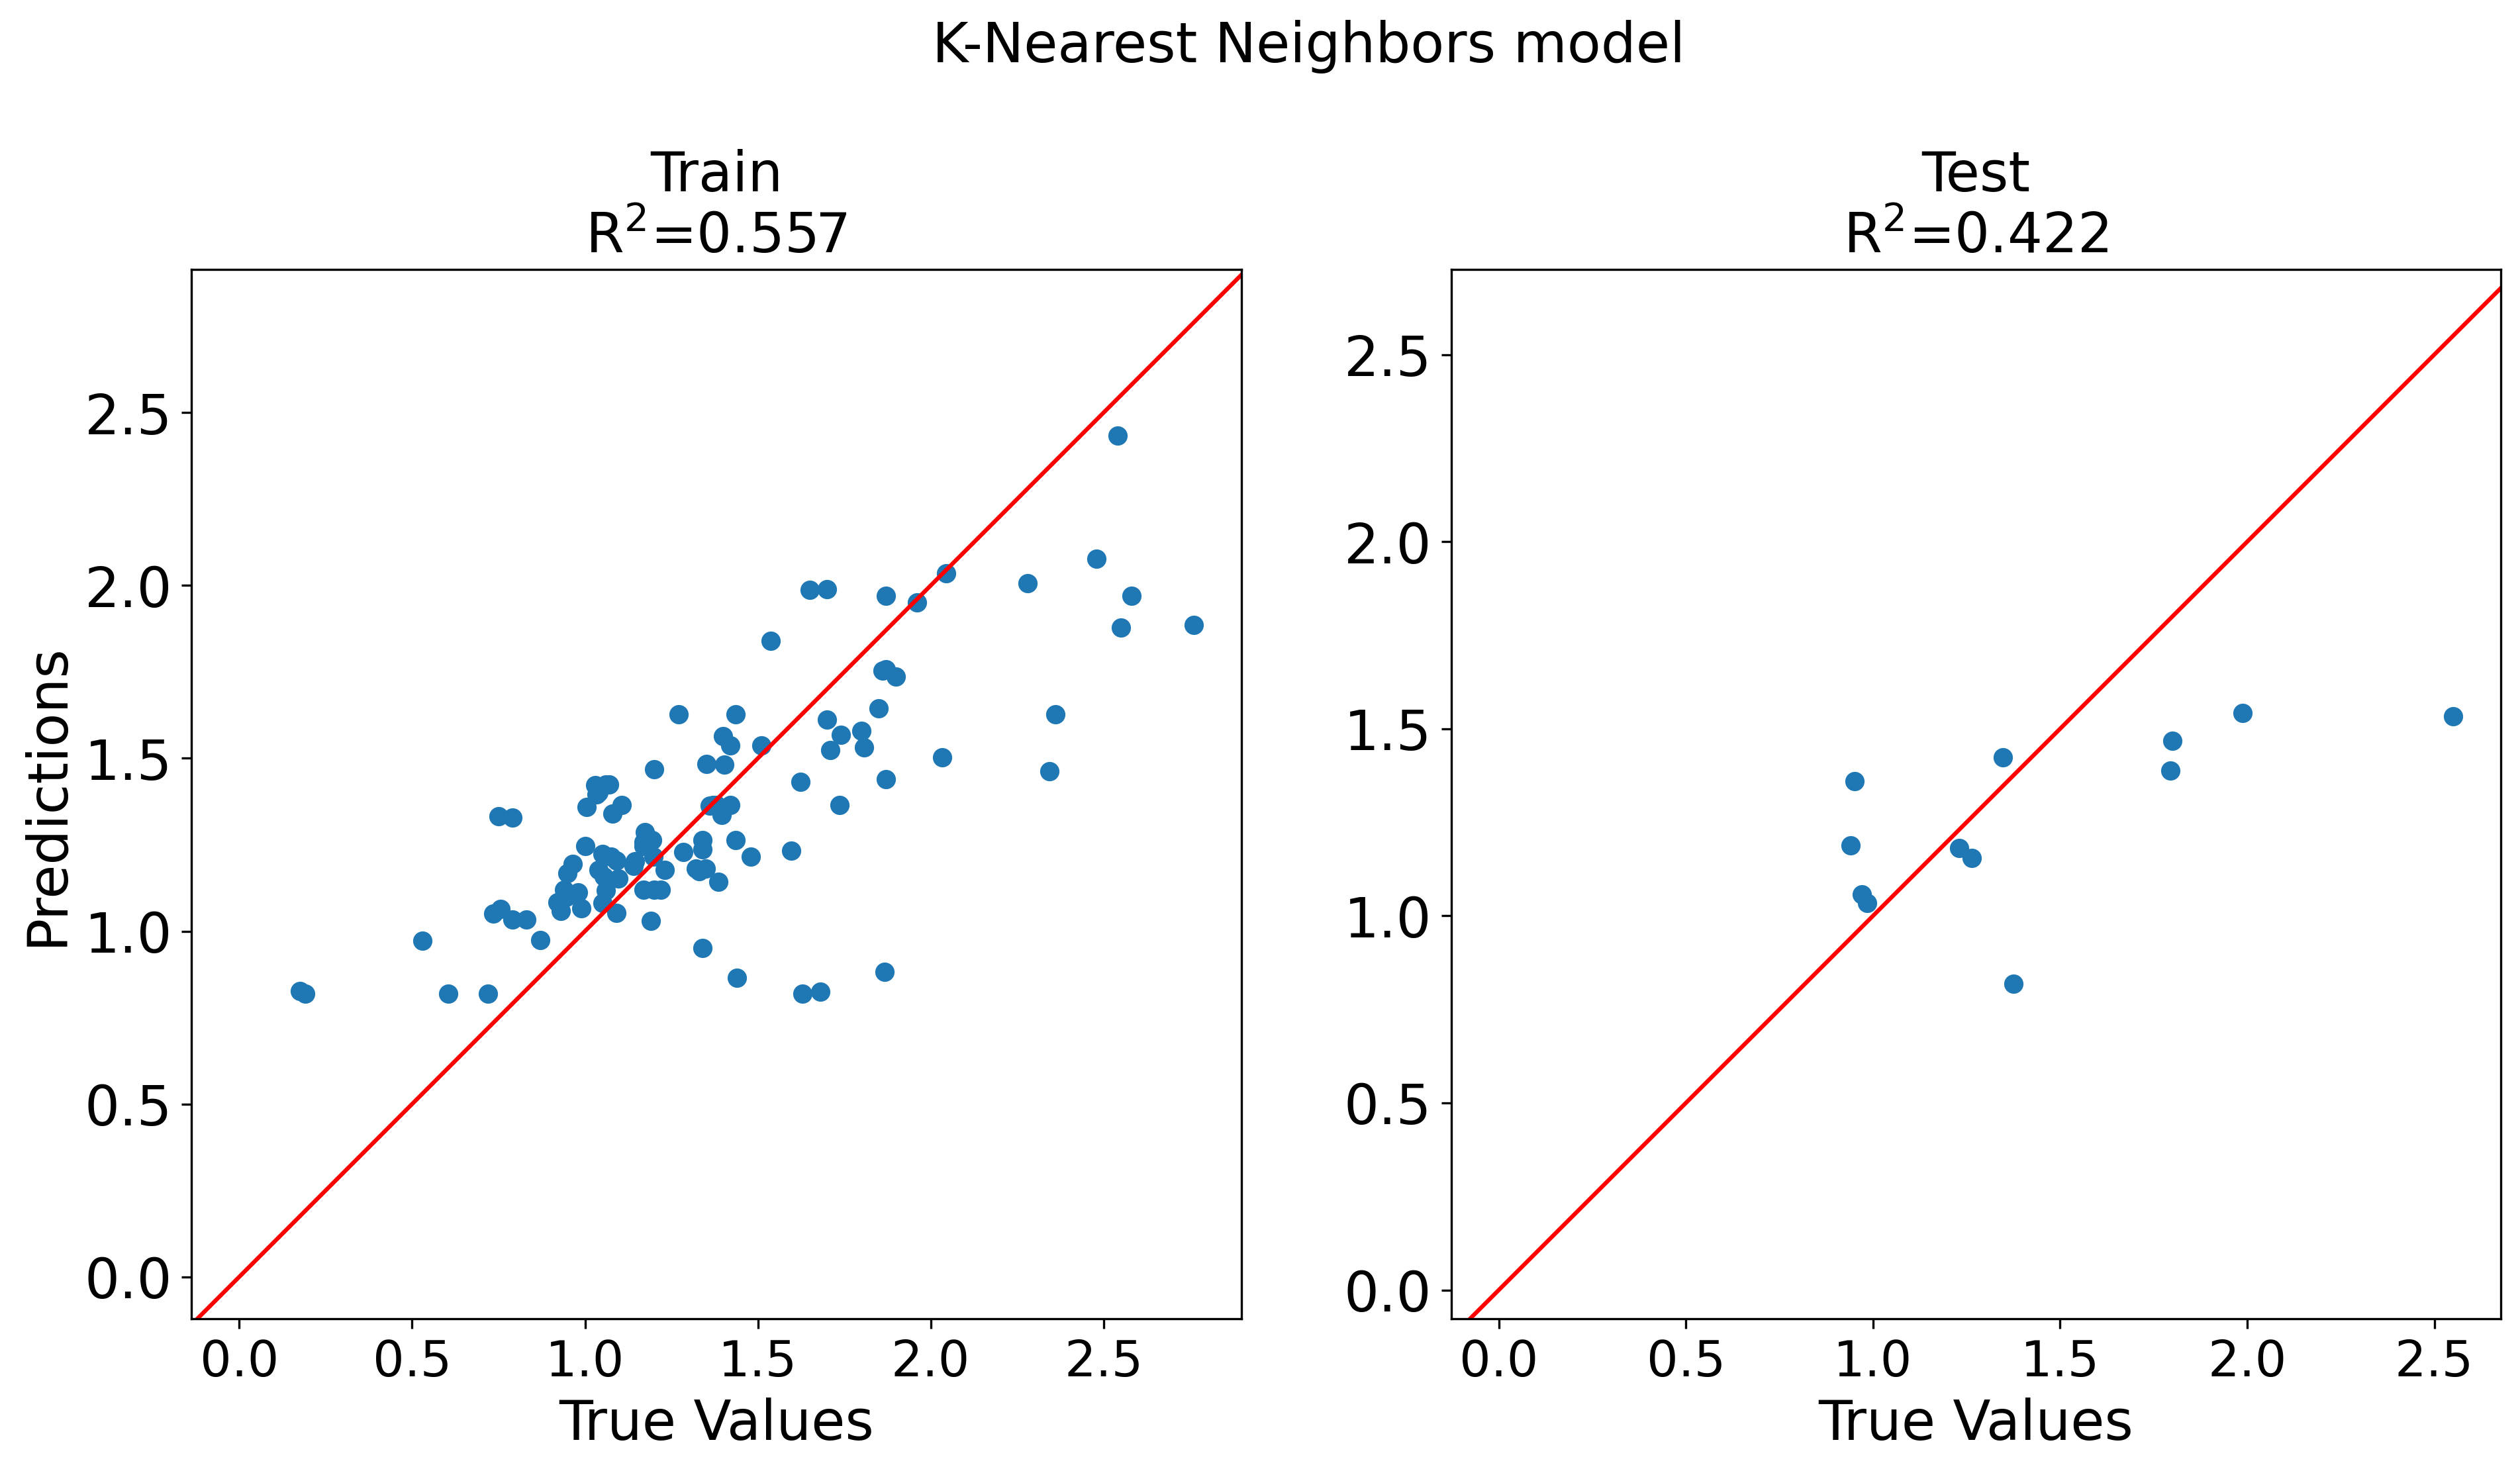

In [48]:
model_name = "K-Nearest Neighbors model"
plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)

In [49]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

## Grid searching

In [50]:
param_grid = [
{'n_neighbors': [5, 6, 7], 'leaf_size': [10, 20, 30, 40, 50],'weights':['uniform', 'distance'] }]
knn = KNeighborsRegressor()
knn_grid = GridSearchCV(knn, param_grid, cv=3, verbose=1)
knn_hist = knn_grid.fit(X_train, Y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [51]:
knn_hist.best_params_

{'leaf_size': 10, 'n_neighbors': 5, 'weights': 'uniform'}

In [52]:
knn_best = KNeighborsRegressor(**knn_hist.best_params_)
knn_best.fit(X_train, Y_train)

KNeighborsRegressor(leaf_size=10)

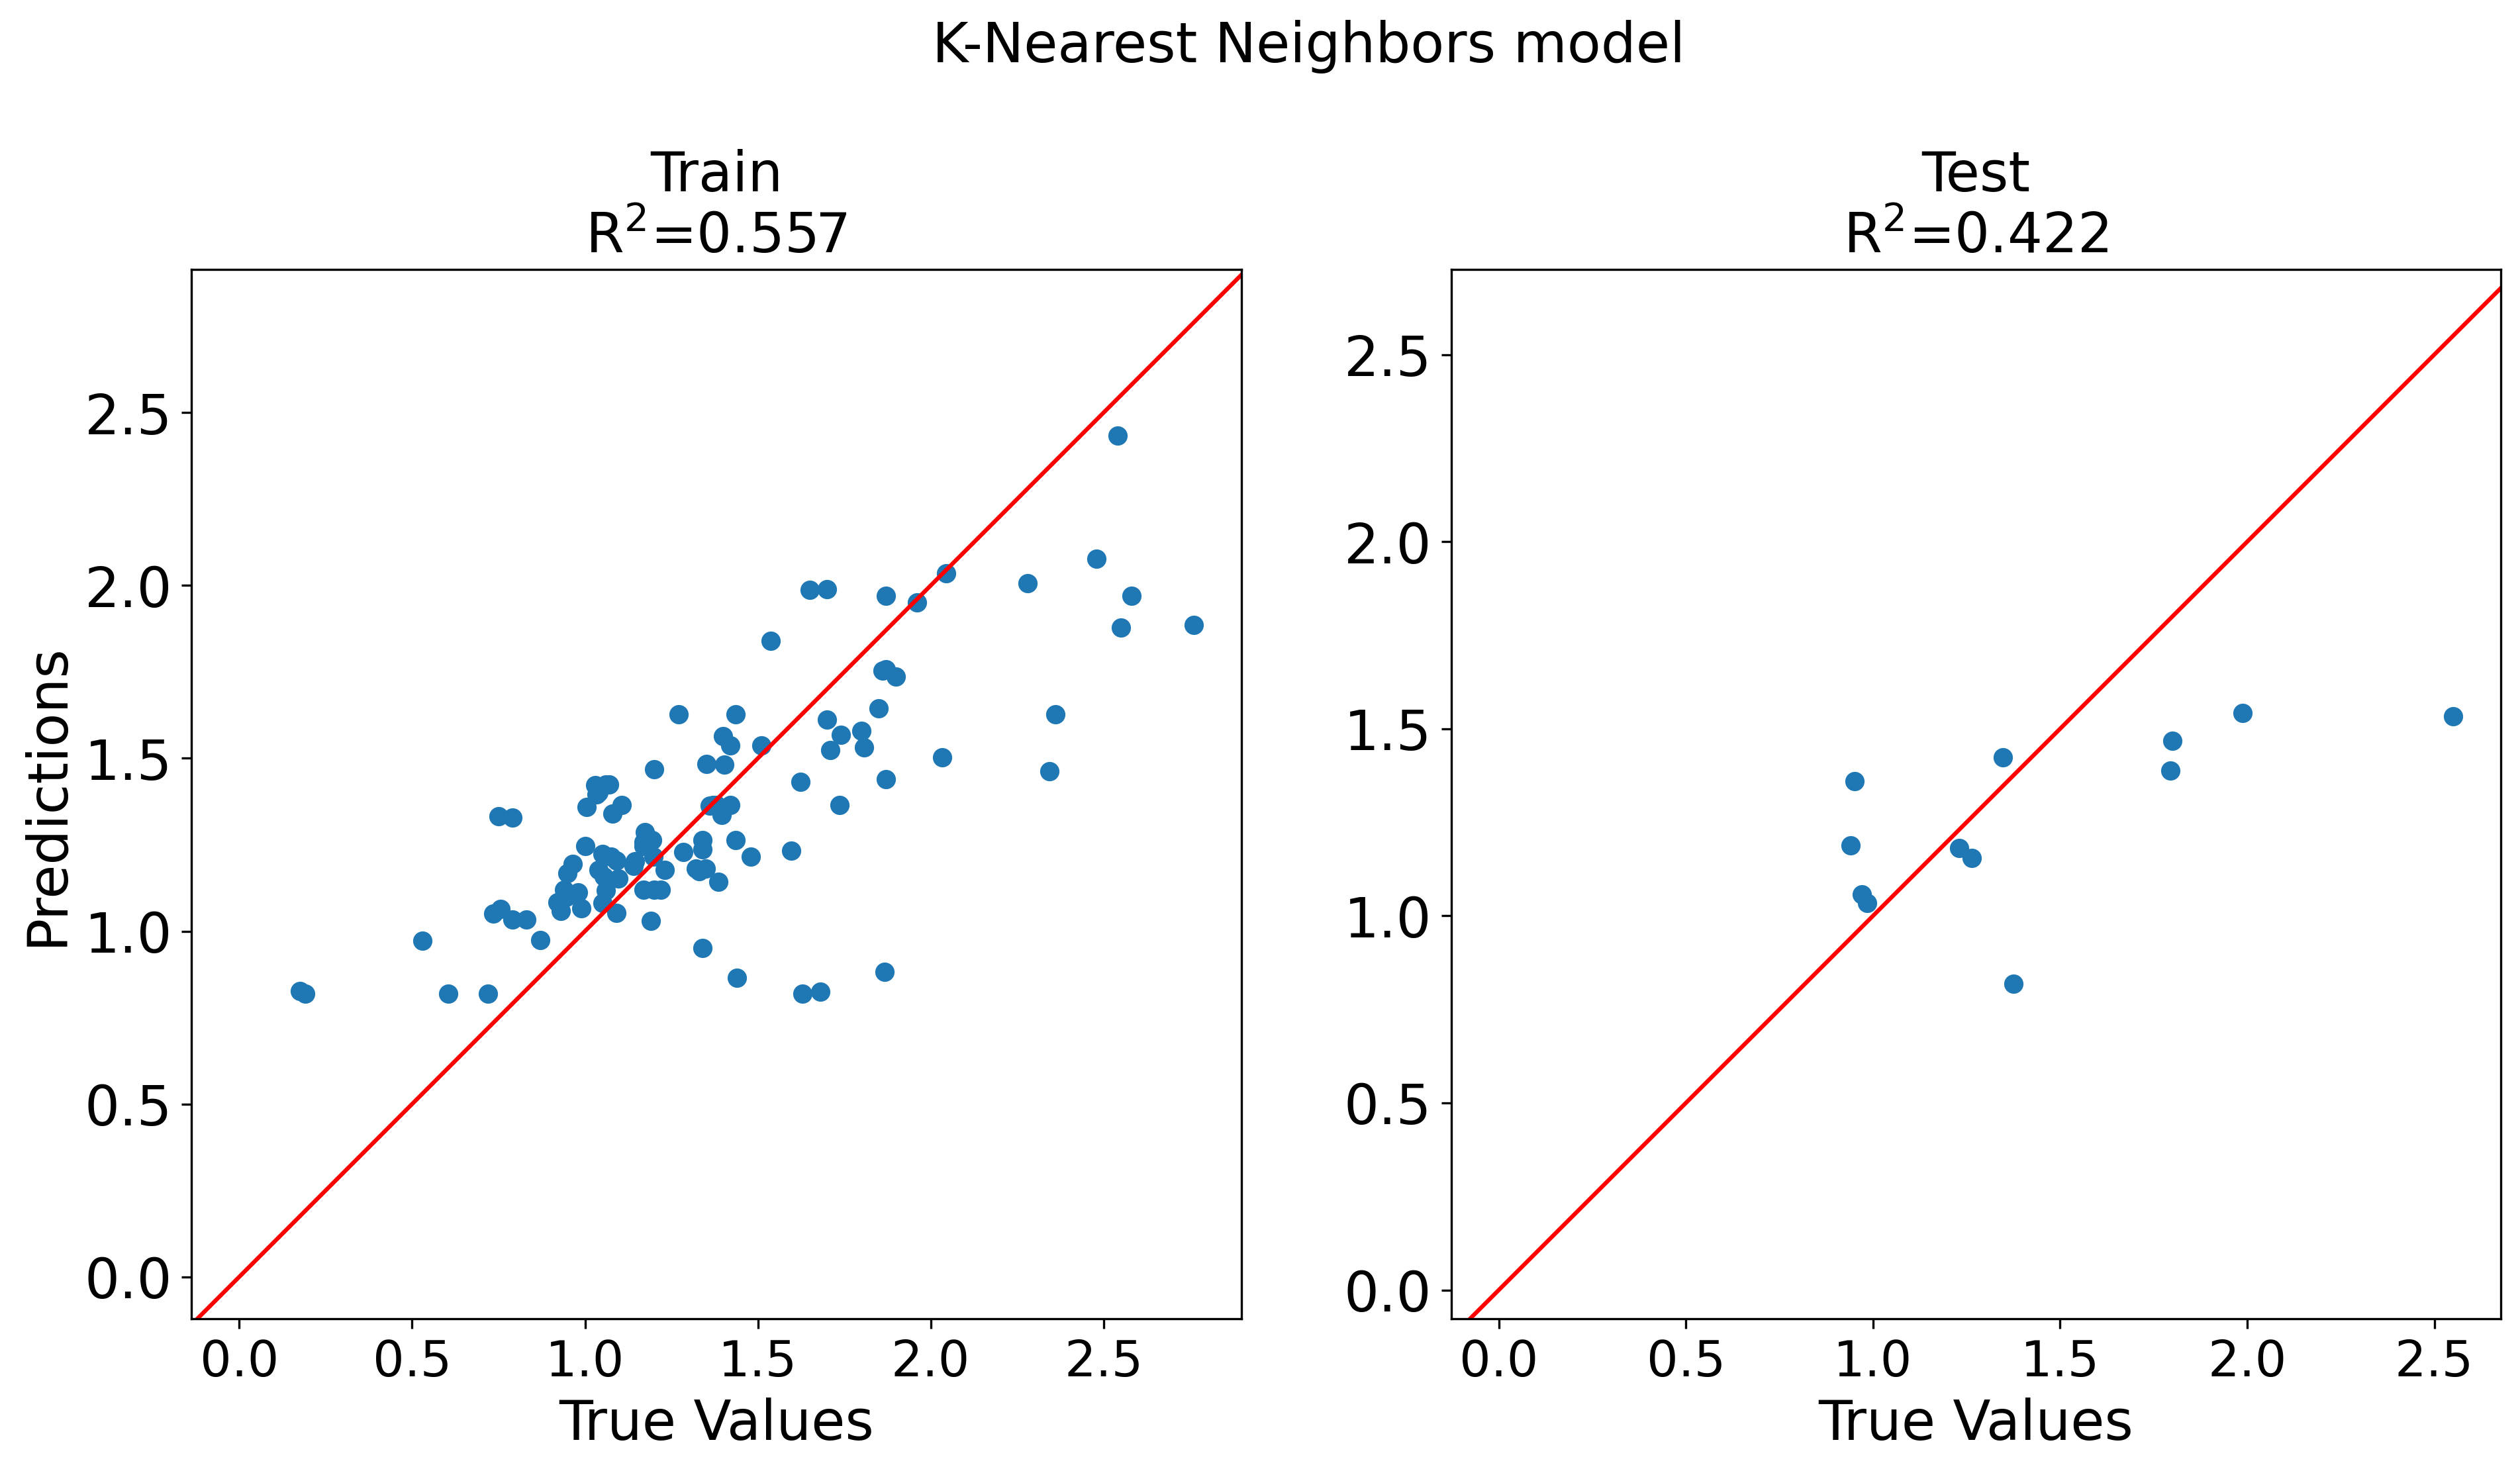

In [53]:
y_pred_train = knn_best.predict(X_train)
y_pred_test = knn_best.predict(X_test)
test_results['KNN'] = metrics.mean_squared_error(Y_test, y_pred_test)
model_name = "K-Nearest Neighbors model"
plot_train_test(model_name,Y_train,y_pred_train,Y_test,y_pred_test)
